In [1]:
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Обнаружение и удаление двигательных артефактов (раздел отчета 4.1)
## Содержание jupyter notebook (ссылки): <a id="contents"></a>
1. [Генерация тестовых сигналов](#gen)
2. [Двигательные артефакты различных типов](#moving_types)
3. [Обнаружение в сигнале двигательных артефактов](#detection)
4. [Удаление двигательных артефактов](#removal)
5. [Проверка алгоритмов на реальных сигналах](#check)

In [4]:
t = np.linspace(0, 60, 20 * 60 + 1)
t

array([0.000e+00, 5.000e-02, 1.000e-01, ..., 5.990e+01, 5.995e+01,
       6.000e+01])

In [5]:
herz = 0.3
signal = np.sin(2 * np.pi * herz * t)
signal

array([ 0.00000000e+00,  9.41083133e-02,  1.87381315e-01, ...,
       -1.87381315e-01, -9.41083133e-02, -4.40872848e-15])

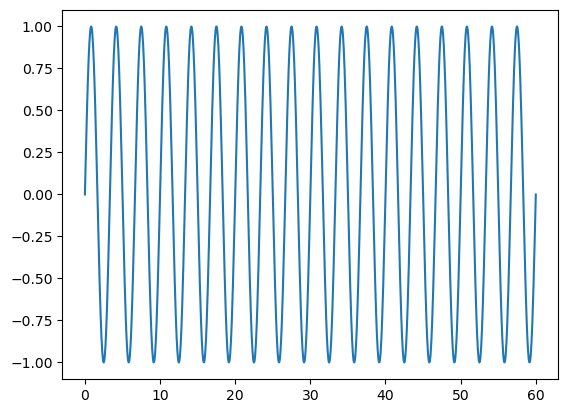

In [9]:
plt.plot(t, signal)

### Генерация тестовых сигналов <a id="gen"></a>
[Вернуться к содержанию](#contents)

In [5]:
sample_rate = 20
duration = 4 * 60

time = np.linspace(0, duration, sample_rate * duration, endpoint=False)
time

array([0.0000e+00, 5.0000e-02, 1.0000e-01, ..., 2.3985e+02, 2.3990e+02,
       2.3995e+02])

In [33]:
len(time)

4800

In [4]:
hz_heart = 1
hz_breath = 0.3
hz_low = 0.1
hz_very_low = 0.05

mu_heart = 3
mu_breath = 1
mu_low = 5
mu_very_low = 4

gamma = 1

In [6]:
noise = gamma * np.random.normal(0, 1, len(time))

heart = mu_heart * np.sin(2 * np.pi * hz_heart * time)
breath = mu_breath * np.sin(2 * np.pi * hz_breath * time)
low = mu_low * np.sin(2 * np.pi * hz_low * time)
very_low = mu_very_low * np.sin(2 * np.pi * hz_very_low * time)

nirs_sim = heart + breath + low + very_low + noise

Пример сгенерированного сигнала

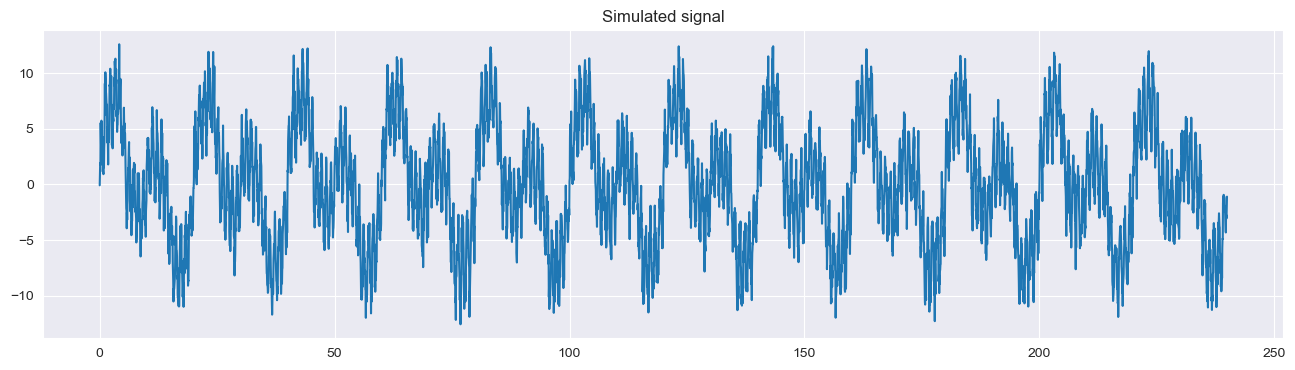

In [7]:
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(time, nirs_sim)
plt.title("Simulated signal")
plt.show()

Часть сгенерированного сигнала

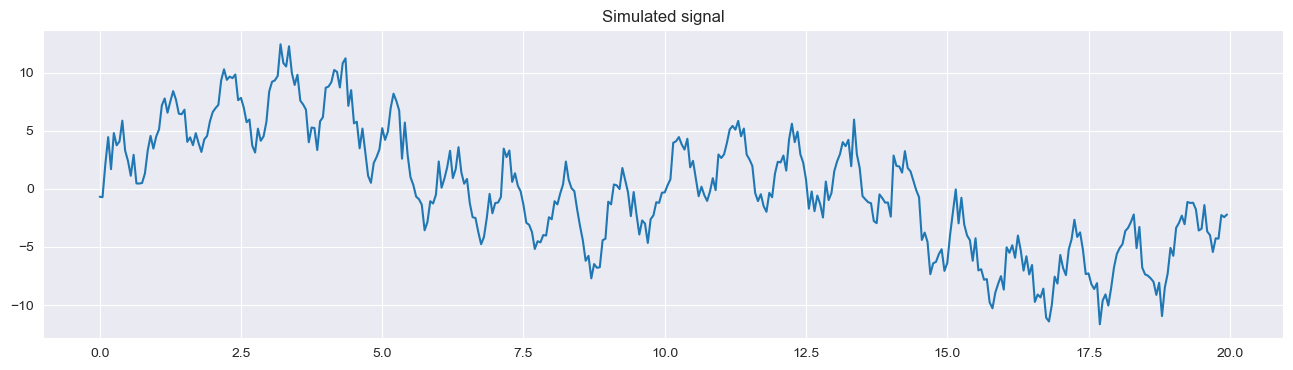

In [100]:
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(time[:400], nirs_sim[:400])
plt.title("Simulated signal")
plt.show()

In [101]:
from scipy.fft import rfft, rfftfreq
n = sample_rate * duration

yf = rfft(nirs_sim)
xf = rfftfreq(n, 1 / sample_rate)

Преобразование Фурье сгенерированного сигнала

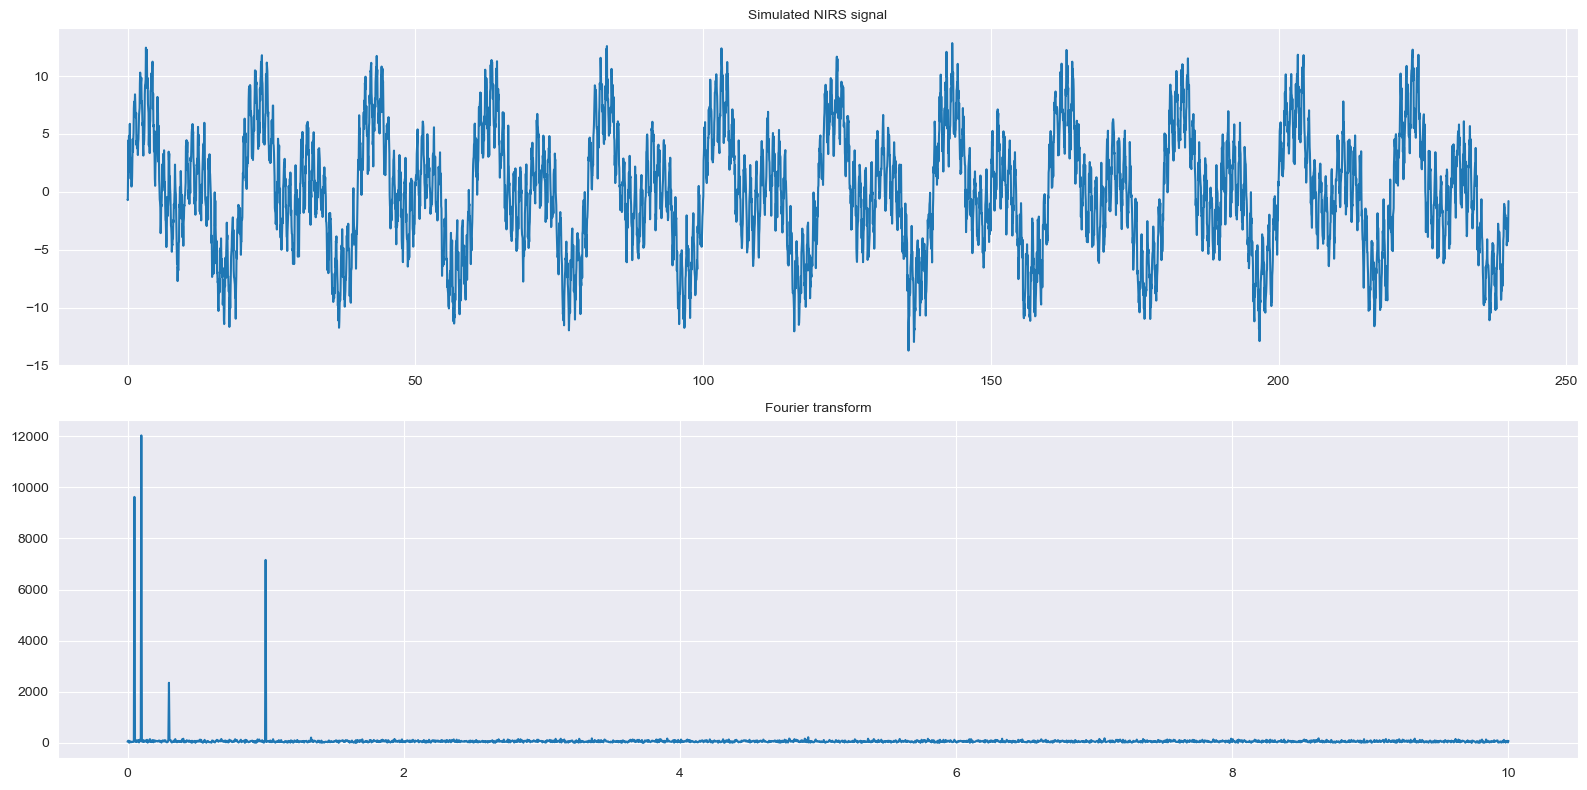

In [102]:
figure, axis = plt.subplots(2, 1, figsize=(16, 8))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Simulated NIRS signal', fontsize=10)
axis[0].plot(time, nirs_sim)

axis[1].set_title('Fourier transform', fontsize=10)
axis[1].plot(xf, np.abs(yf))

plt.tight_layout()
plt.show()

In [38]:
len(nirs_sim)

4800

### Двигательные артефакты различных типов <a id="moving_types"></a>
[Вернуться к содержанию](#contents)

In [166]:
width = 100
def msd(signal):
    return pd.Series(signal).rolling(width, center=True).std().to_numpy()

In [8]:
shift_artifact = np.array([0] * 1600 + [30] * 800 + [-80] * 1600 + [-50] * 800)
shift_artifact

array([  0,   0,   0, ..., -50, -50, -50])

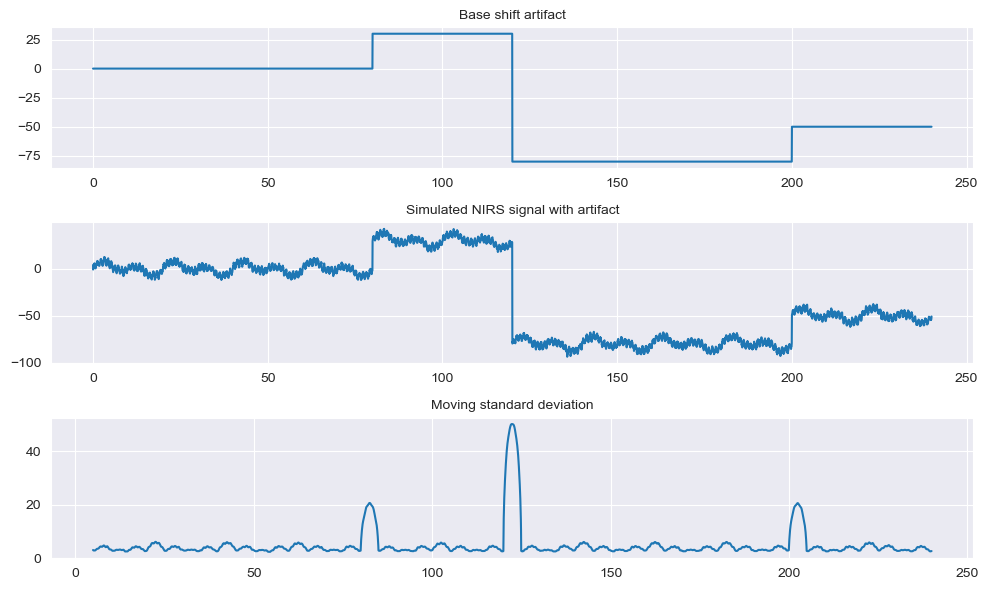

In [114]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Base shift artifact', fontsize=10)
axis[0].plot(time, shift_artifact)

axis[1].set_title('Simulated NIRS signal with artifact', fontsize=10)
axis[1].plot(time, nirs_sim + shift_artifact)

axis[2].set_title('Moving standard deviation', fontsize=10)
axis[2].plot(time, msd(nirs_sim + shift_artifact))

plt.tight_layout()
plt.show()

In [9]:
spike_artifact = np.array([0] * 800 + [150] * 1 + [0] * (2400 - 1) + [-100] * 1 + [0] * (1600 - 1))
spike_artifact

array([0, 0, 0, ..., 0, 0, 0])

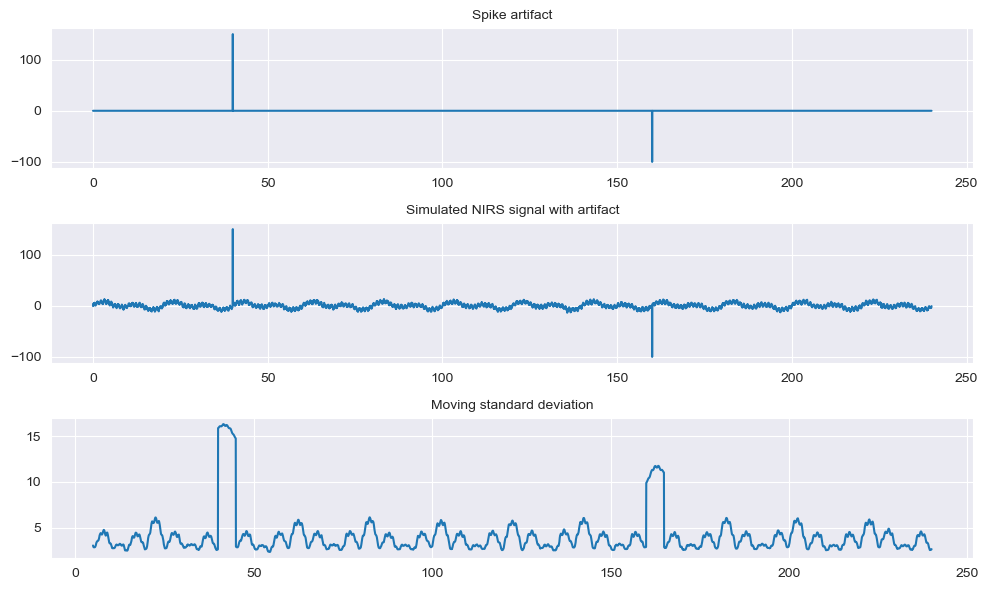

In [116]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Spike artifact', fontsize=10)
axis[0].plot(time, spike_artifact)

axis[1].set_title('Simulated NIRS signal with artifact', fontsize=10)
axis[1].plot(time, nirs_sim + spike_artifact)

axis[2].set_title('Moving standard deviation', fontsize=10)
axis[2].plot(time, msd(nirs_sim + spike_artifact))

plt.tight_layout()
plt.show()

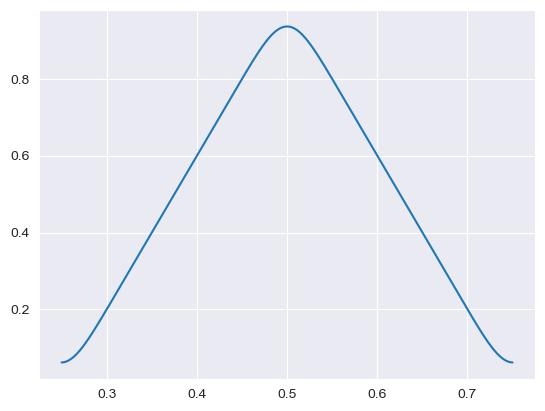

In [10]:
from scipy import signal
from scipy.ndimage import gaussian_filter1d
t = np.linspace(0.25, 0.75, 500)
triangle = gaussian_filter1d(np.abs(signal.sawtooth(2 * np.pi * 2 * t)), 20)
plt.plot(t, triangle)

In [11]:
triangle = triangle - triangle[0]
triangle

array([0.00000000e+00, 1.59805921e-04, 4.79018997e-04, 9.56844677e-04,
       1.59209855e-03, 2.38321516e-03, 3.32825956e-03, 4.42494146e-03,
       5.67063194e-03, 7.06238224e-03, 8.59694474e-03, 1.02707956e-02,
       1.20801588e-02, 1.40210319e-02, 1.60892121e-02, 1.82803234e-02,
       2.05898440e-02, 2.30131340e-02, 2.55454622e-02, 2.81820337e-02,
       3.09180156e-02, 3.37485626e-02, 3.66688410e-02, 3.96740517e-02,
       4.27594519e-02, 4.59203744e-02, 4.91522464e-02, 5.24506056e-02,
       5.58111147e-02, 5.92295746e-02, 6.27019350e-02, 6.62243035e-02,
       6.97929533e-02, 7.34043280e-02, 7.70550465e-02, 8.07419046e-02,
       8.44618763e-02, 8.82121132e-02, 9.19899430e-02, 9.57928666e-02,
       9.96185541e-02, 1.03464841e-01, 1.07329720e-01, 1.11211341e-01,
       1.15107998e-01, 1.19018126e-01, 1.22940291e-01, 1.26873188e-01,
       1.30815627e-01, 1.34766529e-01, 1.38724920e-01, 1.42689920e-01,
       1.46660739e-01, 1.50636667e-01, 1.54617071e-01, 1.58601386e-01,
      

In [12]:
triangle_artifact = np.array([0] * 2400 + list(175 * triangle) + [0] * 1900)
triangle_artifact

array([0., 0., 0., ..., 0., 0., 0.])

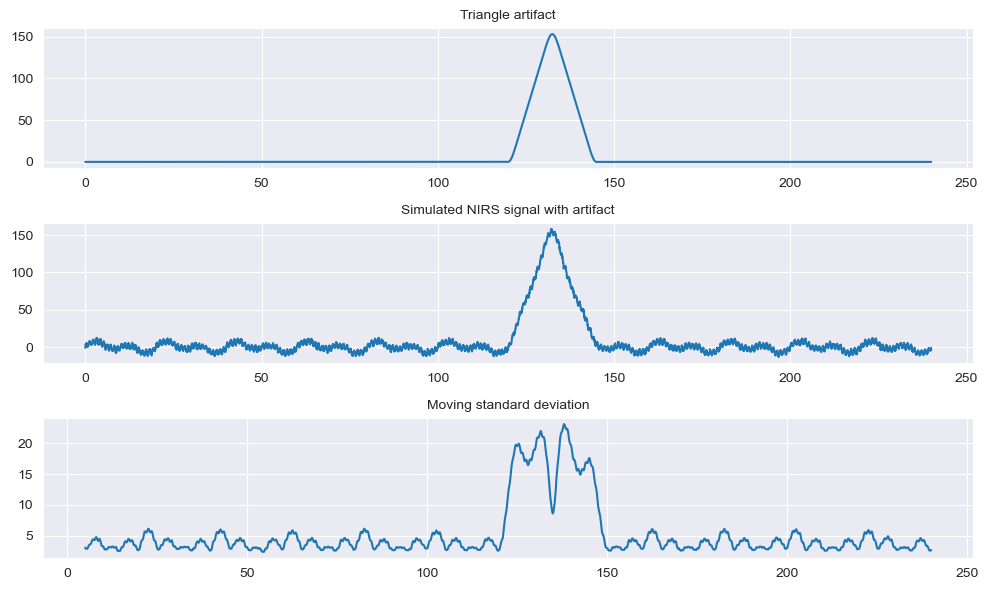

In [152]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Triangle artifact', fontsize=10)
axis[0].plot(time, triangle_artifact)

axis[1].set_title('Simulated NIRS signal with artifact', fontsize=10)
axis[1].plot(time, nirs_sim + triangle_artifact)

axis[2].set_title('Moving standard deviation', fontsize=10)
axis[2].plot(time, msd(nirs_sim + triangle_artifact))

plt.tight_layout()
plt.show()

### Обнаружение в сигнале двигательных артефактов различных типов <a id="detection"></a>
[Вернуться к содержанию](#contents)

In [13]:
nirs_shift = nirs_sim + shift_artifact
nirs_spike = nirs_sim + spike_artifact
nirs_triangle = nirs_sim + triangle_artifact

In [157]:
offset = width // 2

In [14]:
def artifacts(signal, time):
    msd_signal = msd(signal)
    bounds = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < 10 and msd_signal[i] >= 10) or (msd_signal[i] >= 10 and msd_signal[i + 1] < 10):
            bounds.append(time[i])
    return bounds

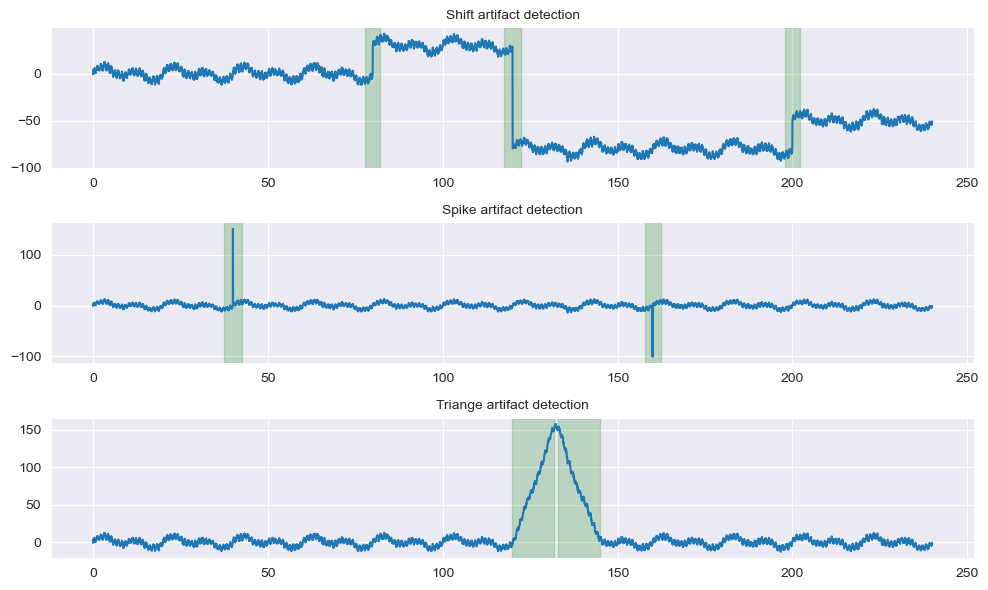

In [162]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, nirs_shift)
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, nirs_spike)
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2].set_title('Triangle artifact detection', fontsize=10)
axis[2].plot(time, nirs_triangle)
bounds = artifacts(nirs_triangle, time)
for i in range(len(bounds) // 2):
    axis[2].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

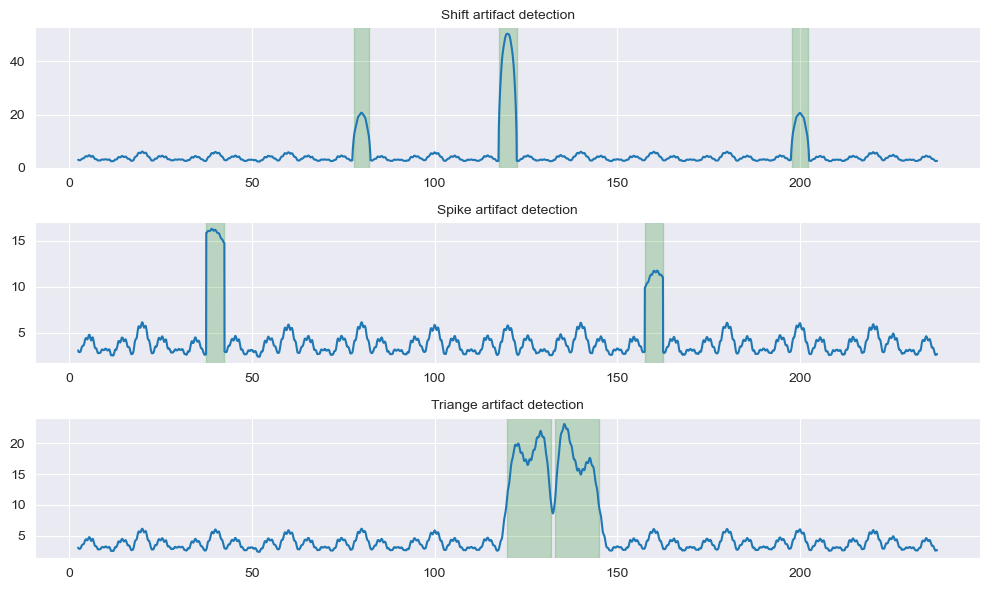

In [163]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, msd(nirs_shift))
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, msd(nirs_spike))
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2].set_title('Triange artifact detection', fontsize=10)
axis[2].plot(time, msd(nirs_triangle))
bounds = artifacts(nirs_triangle, time)
for i in range(len(bounds) // 2):
    axis[2].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

In [169]:
mean_width = 100
def rolling_mean(signal):
    return pd.Series(signal).rolling(mean_width, center=True).mean().to_numpy()

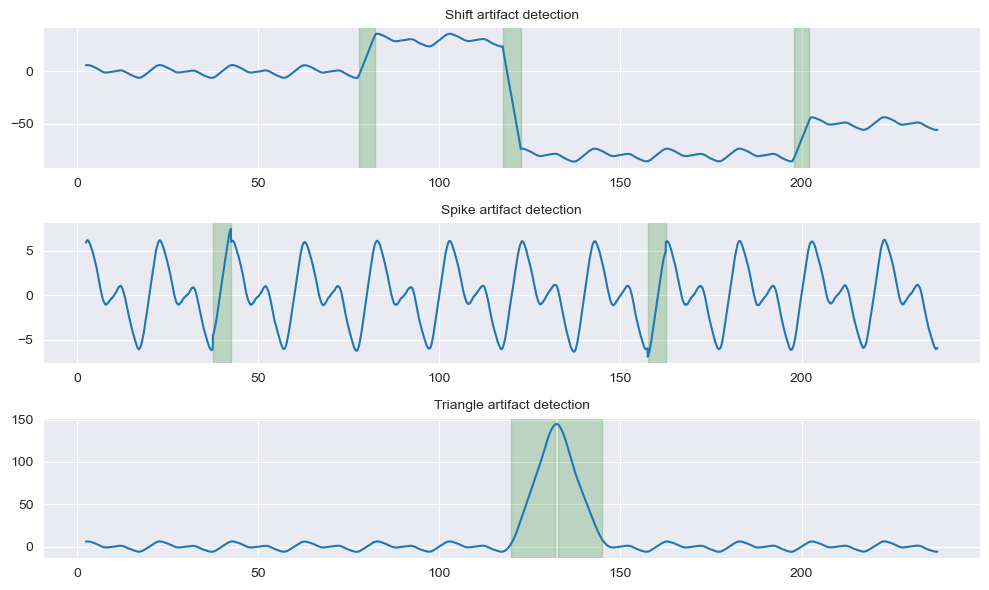

In [170]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, rolling_mean(nirs_shift))
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, rolling_mean(nirs_spike))
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2].set_title('Triangle artifact detection', fontsize=10)
axis[2].plot(time, rolling_mean(nirs_triangle))
bounds = artifacts(nirs_triangle, time)
for i in range(len(bounds) // 2):
    axis[2].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

In [25]:
from scipy.interpolate import splrep, BSpline
import pywt

In [256]:
def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

In [260]:
def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="greater") for i in coeff[1:])
    #coeff = (pywt.threshold(i, value=thresh, mode="greater") for i in coeff)
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

In [232]:
coeff = pywt.wavedec(nirs_shift, "db5")
len(coeff)

10

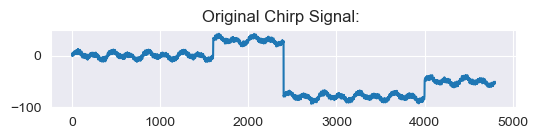

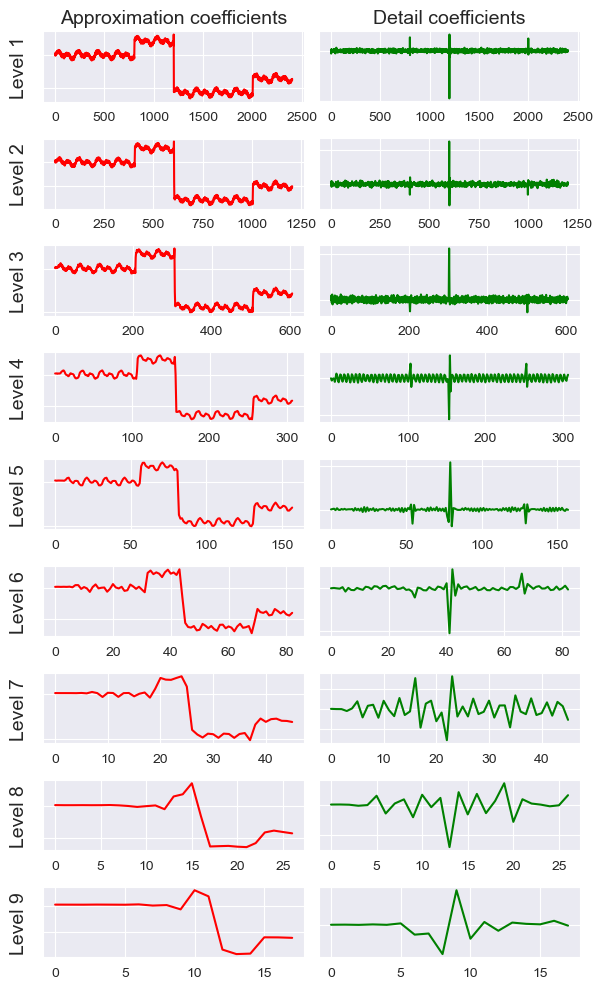

In [236]:
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(nirs_shift)
plt.show()
    
data = nirs_shift
waveletname = 'db5'
 
fig, axarr = plt.subplots(nrows=9, ncols=2, figsize=(6,10))
(data, coeff_d) = pywt.dwt(data, waveletname)
for ii in range(9):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [223]:
def lowpassfilter(signal, thresh = 0.9, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
    return reconstructed_signal

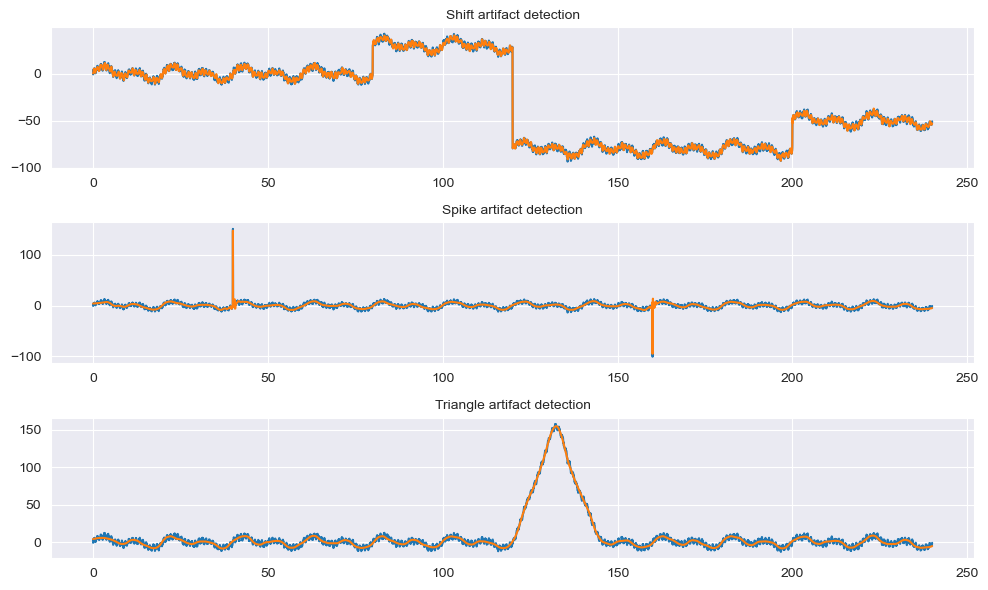

In [227]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, nirs_shift)
axis[0].plot(time, wavelet_filter(nirs_shift))

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, nirs_spike)
axis[1].plot(time, wavelet_filter(nirs_spike))

axis[2].set_title('Triangle artifact detection', fontsize=10)
axis[2].plot(time, nirs_triangle)
axis[2].plot(time, wavelet_filter(nirs_triangle))

plt.tight_layout()
plt.show()

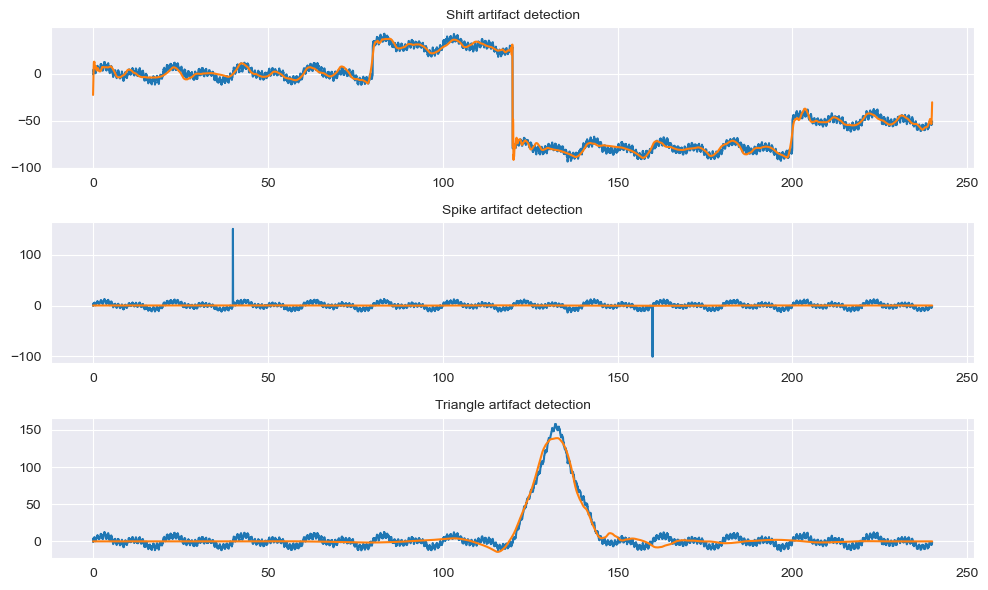

In [220]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, nirs_shift)
axis[0].plot(time, lowpassfilter(nirs_shift))

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, nirs_spike)
axis[1].plot(time, lowpassfilter(nirs_spike))

axis[2].set_title('Triangle artifact detection', fontsize=10)
axis[2].plot(time, nirs_triangle)
axis[2].plot(time, lowpassfilter(nirs_triangle))

plt.tight_layout()
plt.show()

In [241]:
def artifacts_index(signal, time):
    msd_signal = msd(signal)
    indices = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < 10 and msd_signal[i] >= 10) or (msd_signal[i] >= 10 and msd_signal[i + 1] < 10):
            indices.append(i)
    return indices

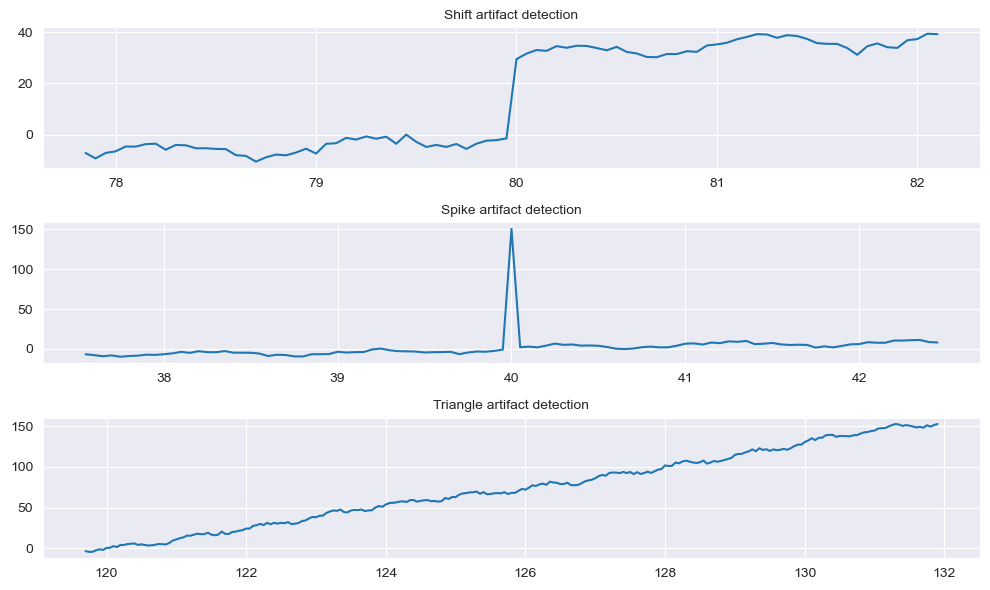

In [243]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
indices = artifacts_index(nirs_shift, time)
axis[0].plot(time[indices[0]:indices[1]], nirs_shift[indices[0]:indices[1]])


axis[1].set_title('Spike artifact detection', fontsize=10)
indices = artifacts_index(nirs_spike, time)
axis[1].plot(time[indices[0]:indices[1]], nirs_spike[indices[0]:indices[1]])


axis[2].set_title('Triangle artifact detection', fontsize=10)
indices = artifacts_index(nirs_triangle, time)
axis[2].plot(time[indices[0]:indices[1]], nirs_triangle[indices[0]:indices[1]])


plt.tight_layout()
plt.show()

In [282]:
def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

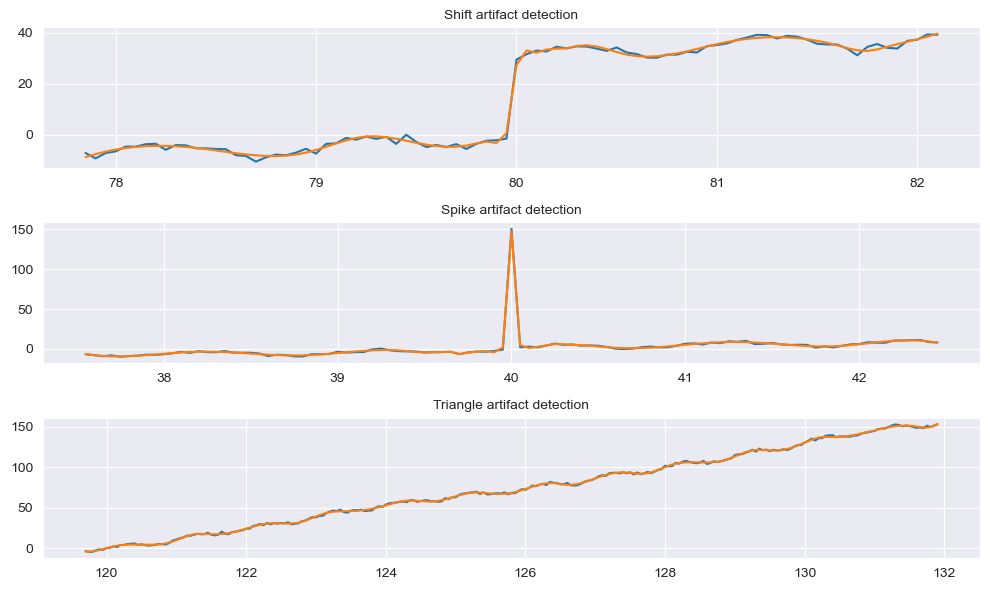

In [283]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
indices = artifacts_index(nirs_shift, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_shift[indices[0]:indices[1]]
axis[0].plot(art_time, art_nirs)
axis[0].plot(art_time, spline(art_time, art_nirs))

axis[1].set_title('Spike artifact detection', fontsize=10)
indices = artifacts_index(nirs_spike, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_spike[indices[0]:indices[1]]
axis[1].plot(art_time, art_nirs)
axis[1].plot(art_time, spline(art_time, art_nirs))


axis[2].set_title('Triangle artifact detection', fontsize=10)
indices = artifacts_index(nirs_triangle, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_triangle[indices[0]:indices[1]]
axis[2].plot(art_time, art_nirs)
axis[2].plot(art_time, spline(art_time, art_nirs))


plt.tight_layout()
plt.show()

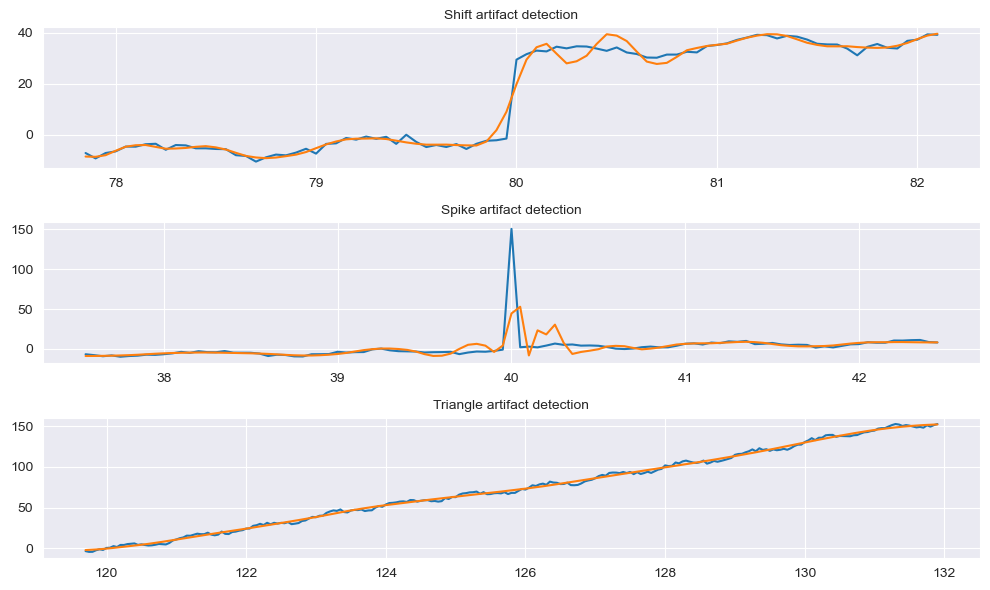

In [261]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
indices = artifacts_index(nirs_shift, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_shift[indices[0]:indices[1]]
axis[0].plot(art_time, art_nirs)
axis[0].plot(art_time, wavelet_filter(art_nirs))

axis[1].set_title('Spike artifact detection', fontsize=10)
indices = artifacts_index(nirs_spike, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_spike[indices[0]:indices[1]]
axis[1].plot(art_time, art_nirs)
axis[1].plot(art_time, wavelet_filter(art_nirs))


axis[2].set_title('Triangle artifact detection', fontsize=10)
indices = artifacts_index(nirs_triangle, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_triangle[indices[0]:indices[1]]
axis[2].plot(art_time, art_nirs)
axis[2].plot(art_time, wavelet_filter(art_nirs))


plt.tight_layout()
plt.show()

In [280]:
def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    #coeff = (pywt.threshold(i, value=thresh, mode="greater") for i in coeff)
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

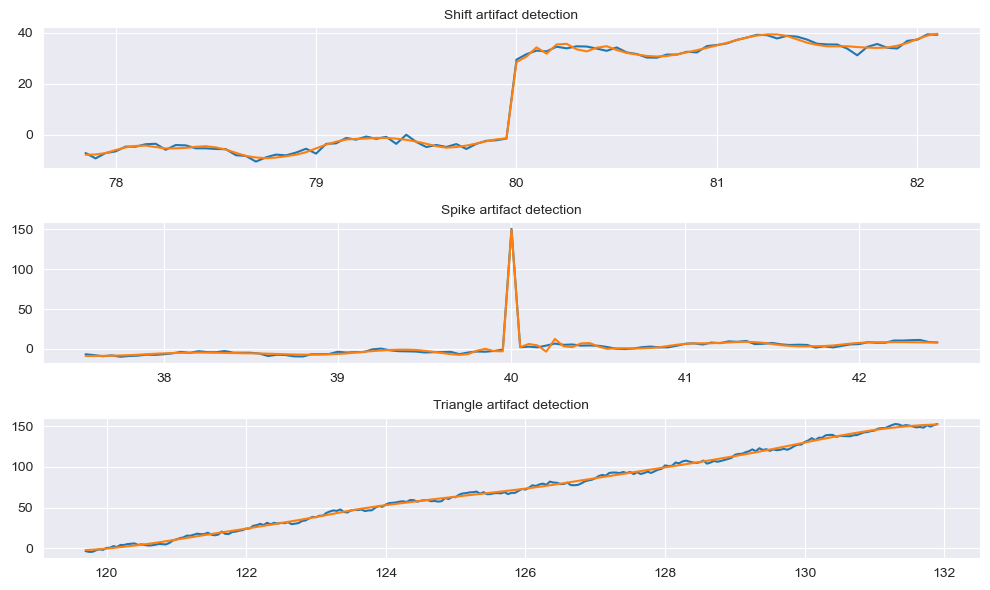

In [281]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
indices = artifacts_index(nirs_shift, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_shift[indices[0]:indices[1]]
axis[0].plot(art_time, art_nirs)
axis[0].plot(art_time, wavelet_filter(art_nirs))

axis[1].set_title('Spike artifact detection', fontsize=10)
indices = artifacts_index(nirs_spike, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_spike[indices[0]:indices[1]]
axis[1].plot(art_time, art_nirs)
axis[1].plot(art_time, wavelet_filter(art_nirs))


axis[2].set_title('Triangle artifact detection', fontsize=10)
indices = artifacts_index(nirs_triangle, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_triangle[indices[0]:indices[1]]
axis[2].plot(art_time, art_nirs)
axis[2].plot(art_time, wavelet_filter(art_nirs))


plt.tight_layout()
plt.show()

In [15]:
width = 25
def msd(signal):
    return pd.Series(signal).rolling(width, center=True).std().to_numpy()

In [16]:
def artifacts(signal, time):
    msd_signal = msd(signal)
    bounds = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < 10 and msd_signal[i] >= 10) or (msd_signal[i] >= 10 and msd_signal[i + 1] < 10):
            bounds.append(time[i])
    return bounds

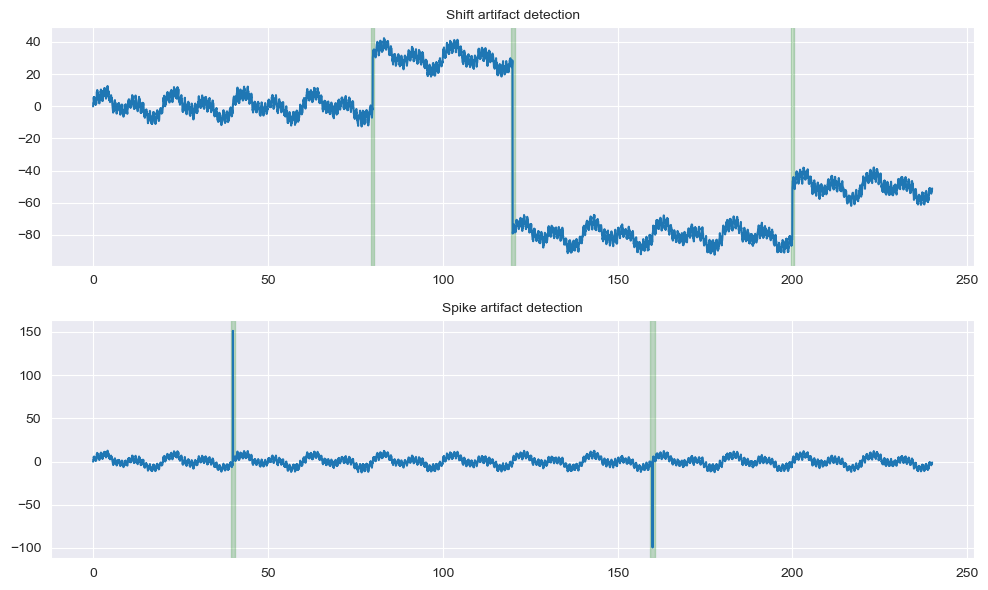

In [17]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, nirs_shift)
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, nirs_spike)
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

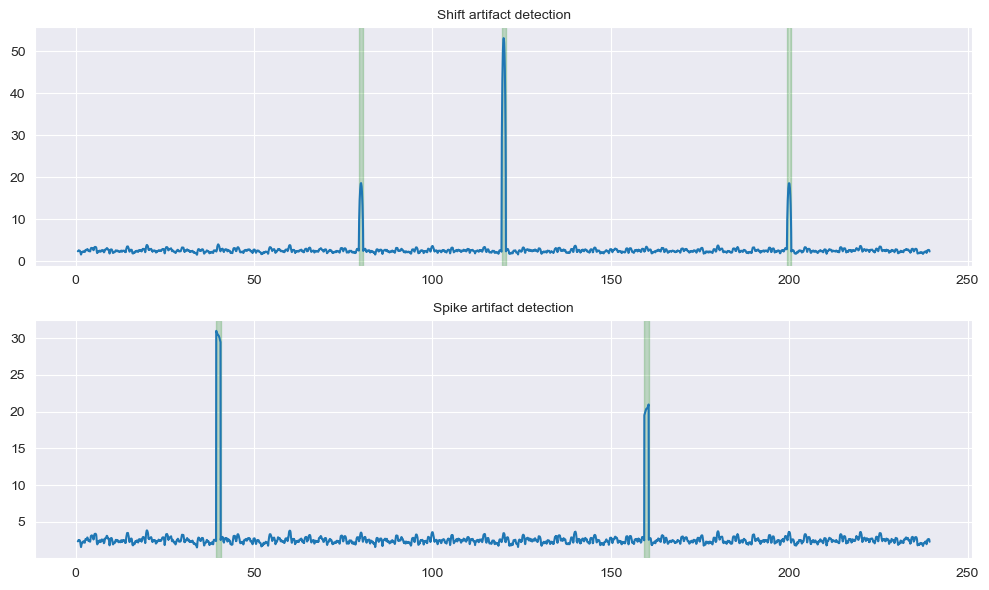

In [312]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, msd(nirs_shift))
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, msd(nirs_spike))
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

In [330]:
def artifacts_index(signal, time):
    msd_signal = msd(signal)
    indices = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < 10 and msd_signal[i] >= 10) or (msd_signal[i] >= 10 and msd_signal[i + 1] < 10):
            indices.append(i)
    return indices

In [328]:
def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

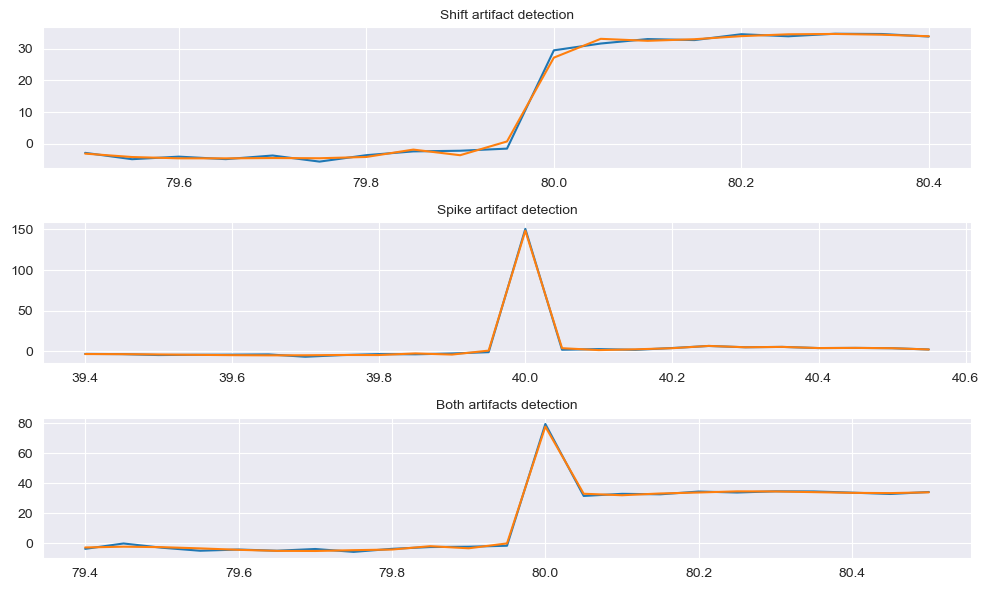

In [332]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
indices = artifacts_index(nirs_shift, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_shift[indices[0]:indices[1]]
axis[0].plot(art_time, art_nirs)
axis[0].plot(art_time, spline(art_time, art_nirs))

axis[1].set_title('Spike artifact detection', fontsize=10)
indices = artifacts_index(nirs_spike, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_spike[indices[0]:indices[1]]
axis[1].plot(art_time, art_nirs)
axis[1].plot(art_time, spline(art_time, art_nirs))

axis[2].set_title('Both artifacts detection', fontsize=10)
indices = artifacts_index(nirs_both, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_both[indices[0]:indices[1]]
axis[2].plot(art_time, art_nirs)
axis[2].plot(art_time, spline(art_time, art_nirs))

plt.tight_layout()
plt.show()

In [336]:
def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

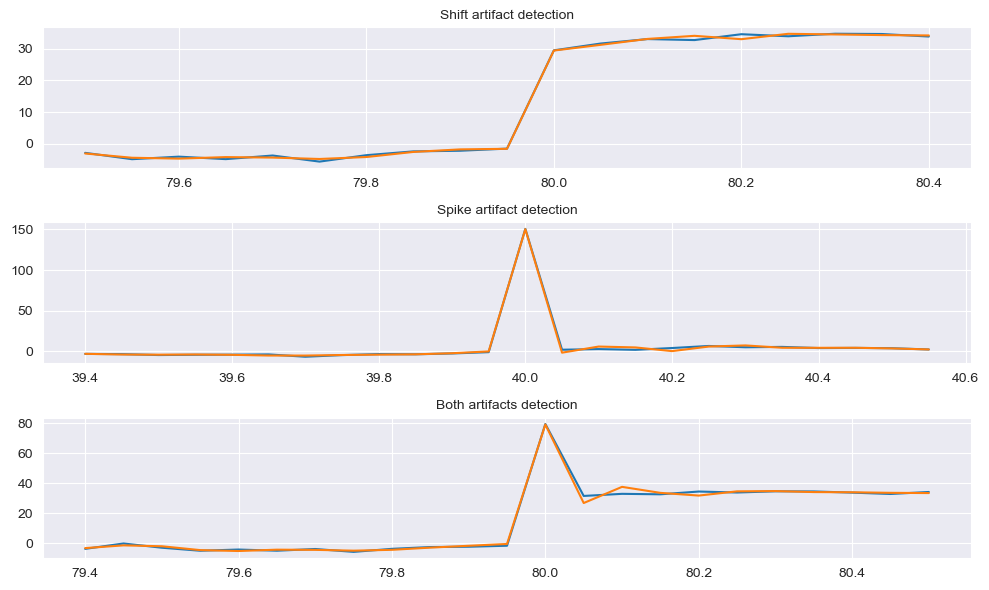

In [338]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
indices = artifacts_index(nirs_shift, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_shift[indices[0]:indices[1]]
axis[0].plot(art_time, art_nirs)
axis[0].plot(art_time, wavelet_filter(art_nirs))

axis[1].set_title('Spike artifact detection', fontsize=10)
indices = artifacts_index(nirs_spike, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_spike[indices[0]:indices[1]]
axis[1].plot(art_time, art_nirs)
axis[1].plot(art_time, wavelet_filter(art_nirs))

axis[2].set_title('Both artifacts detection', fontsize=10)
indices = artifacts_index(nirs_both, time)
art_time, art_nirs = time[indices[0]:indices[1]], nirs_both[indices[0]:indices[1]]
axis[2].plot(art_time, art_nirs)
axis[2].plot(art_time, wavelet_filter(art_nirs))

plt.tight_layout()
plt.show()

### Реализация различных способов удаления двигательных артефактов <a id="removal"></a>
[Вернуться к содержанию](#contents)

In [18]:
import operator

In [38]:
def denoise(signal):
    pass

def artifacts_index(signal, thresh=10):
    msd_signal = msd(signal)
    indices = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < thresh and msd_signal[i] >= thresh) or \
            (msd_signal[i] >= thresh and msd_signal[i + 1] < thresh):
            indices.append(i)
    return indices

def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

def remove_artifacts_spline(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = spline(art_time, art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_wavelet(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = wavelet_filter(art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def shift_parts(signal, indices):
    new_signal = signal.copy()
    indices.insert(0, 0)
    indices.append(len(signal))
    for i in range(1, len(indices) - 1):
        mean_b = np.mean(new_signal[indices[i-1]:indices[i]])
        mean_a = np.mean(signal[indices[i]:indices[i+1]])
        diff = mean_a - mean_b
        new_signal[indices[i]:indices[i+1]] = list(np.array(signal[indices[i]:indices[i+1]]) - diff)
    return new_signal

def preprocess_spline(time, signal):
    signal, indices = remove_artifacts_spline(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_wavelet(time, signal):
    signal, indices = remove_artifacts_wavelet(time, signal)
    signal = shift_parts(signal, indices)
    return signal

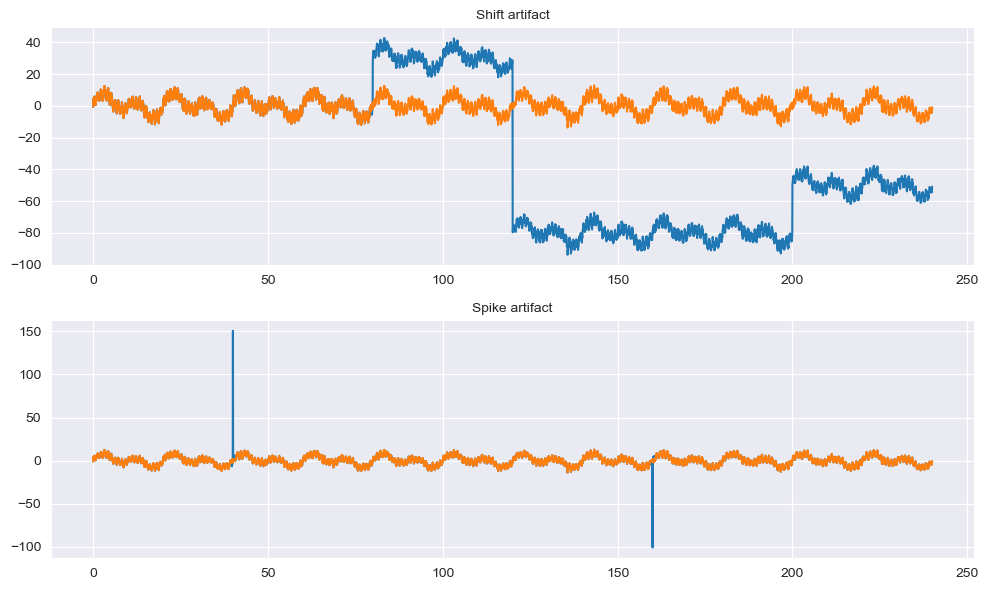

In [321]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact', fontsize=10)
axis[0].plot(time, nirs_shift)
axis[0].plot(time, preprocess_spline(time, nirs_shift))

axis[1].set_title('Spike artifact', fontsize=10)
axis[1].plot(time, nirs_spike)
axis[1].plot(time, preprocess_spline(time, nirs_spike))


plt.tight_layout()
plt.show()

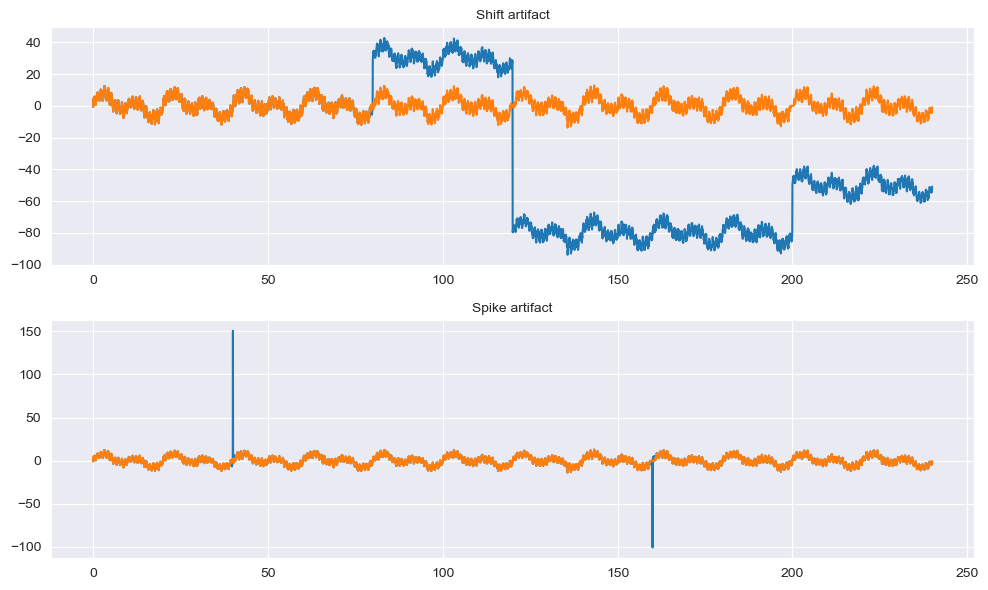

In [322]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact', fontsize=10)
axis[0].plot(time, nirs_shift)
axis[0].plot(time, preprocess_wavelet(time, nirs_shift))

axis[1].set_title('Spike artifact', fontsize=10)
axis[1].plot(time, nirs_spike)
axis[1].plot(time, preprocess_wavelet(time, nirs_spike))


plt.tight_layout()
plt.show()

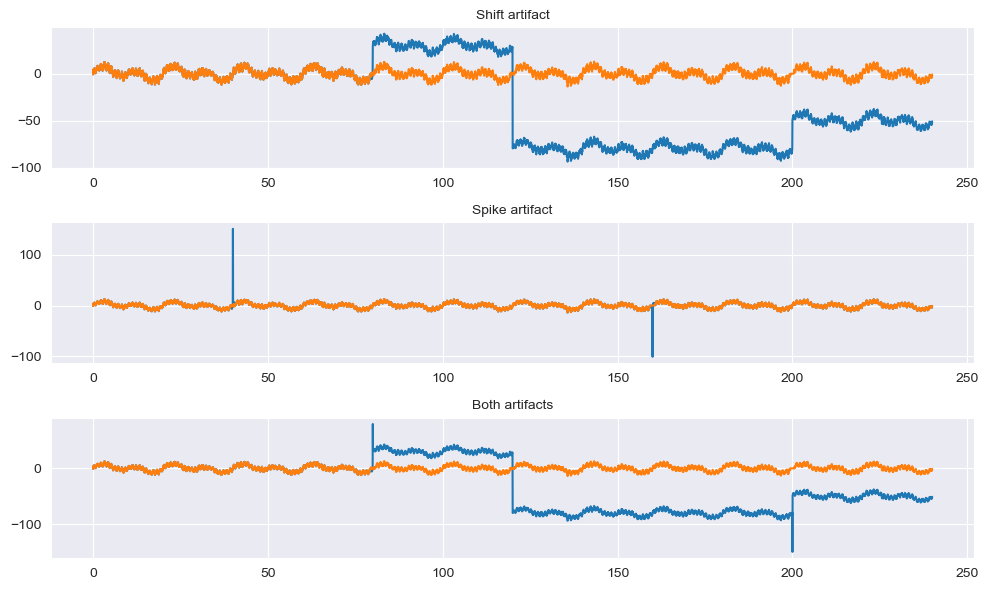

In [325]:
shift_artifact = np.array([0] * 1600 + [30] * 800 + [-80] * 1600 + [-50] * 800)
spike_artifact = np.array([0] * 1600 + [50] * 1 + [0] * (2400 - 1) + [-100] * 1 + [0] * (800 - 1))
nirs_both = nirs_sim + shift_artifact + spike_artifact

figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact', fontsize=10)
axis[0].plot(time, nirs_shift)
axis[0].plot(time, preprocess_wavelet(time, nirs_shift))

axis[1].set_title('Spike artifact', fontsize=10)
axis[1].plot(time, nirs_spike)
axis[1].plot(time, preprocess_wavelet(time, nirs_spike))

axis[2].set_title('Both artifacts', fontsize=10)
axis[2].plot(time, nirs_both)
axis[2].plot(time, preprocess_wavelet(time, nirs_both))


plt.tight_layout()
plt.show()

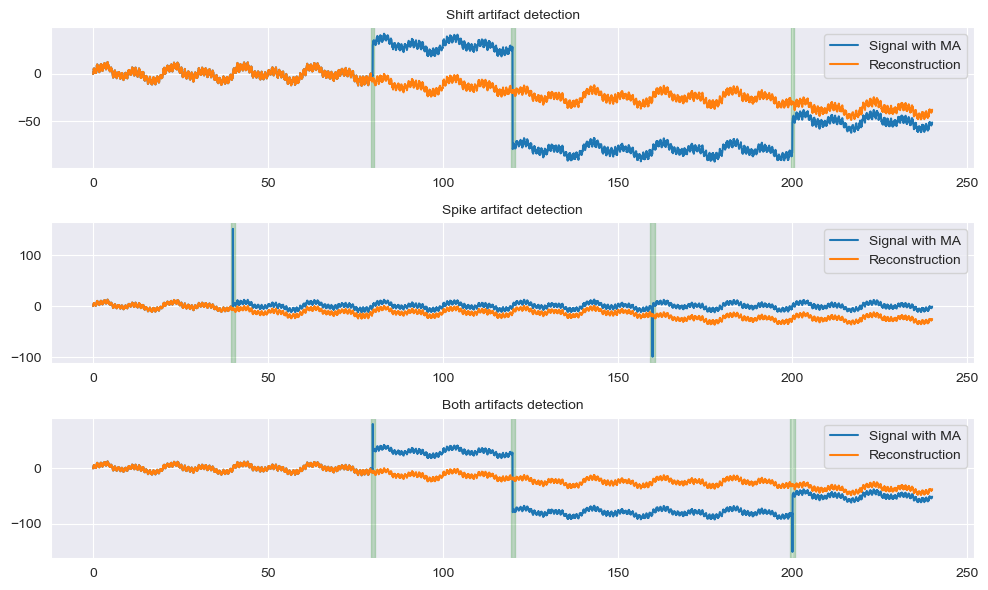

In [37]:
figure, axis = plt.subplots(3, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(time, nirs_shift)
axis[0].plot(time, preprocess_spline(time, nirs_shift))
axis[0].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Spike artifact detection', fontsize=10)
axis[1].plot(time, nirs_spike)
axis[1].plot(time, preprocess_spline(time, nirs_spike))
axis[1].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2].set_title('Both artifacts detection', fontsize=10)
axis[2].plot(time, nirs_both)
axis[2].plot(time, preprocess_spline(time, nirs_both))
axis[2].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_both, time)
for i in range(len(bounds) // 2):
    axis[2].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

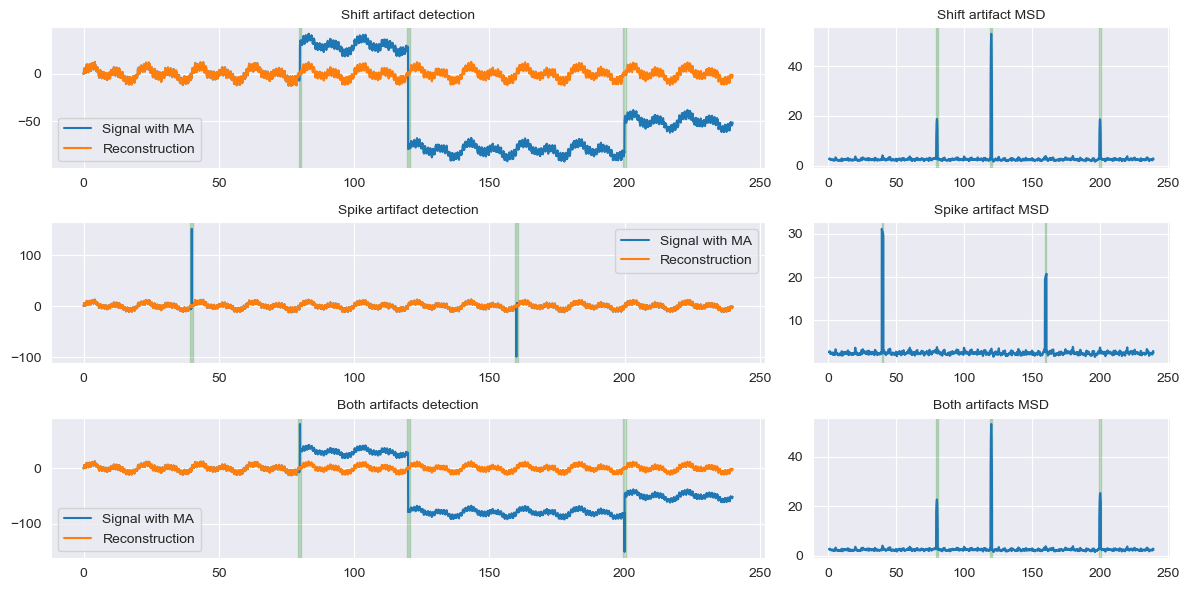

In [41]:
figure, axis = plt.subplots(3, 2, figsize=(12, 6), width_ratios=[2, 1])
#plt.subplots_adjust(hspace=1.0)
axis[0, 0].set_title('Shift artifact detection', fontsize=10)
axis[0, 0].plot(time, nirs_shift)
axis[0, 0].plot(time, preprocess_spline(time, nirs_shift))
axis[0, 0].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0, 0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[0, 1].set_title('Shift artifact MSD', fontsize=10)
axis[0, 1].plot(time, msd(nirs_shift))
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0, 1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1, 0].set_title('Spike artifact detection', fontsize=10)
axis[1, 0].plot(time, nirs_spike)
axis[1, 0].plot(time, preprocess_spline(time, nirs_spike))
axis[1, 0].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1, 0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1, 1].set_title('Spike artifact MSD', fontsize=10)
axis[1, 1].plot(time, msd(nirs_spike))
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1, 1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2, 0].set_title('Both artifacts detection', fontsize=10)
axis[2, 0].plot(time, nirs_both)
axis[2, 0].plot(time, preprocess_spline(time, nirs_both))
axis[2, 0].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_both, time)
for i in range(len(bounds) // 2):
    axis[2, 0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2, 1].set_title('Both artifacts MSD', fontsize=10)
axis[2, 1].plot(time, msd(nirs_both))
bounds = artifacts(nirs_both, time)
for i in range(len(bounds) // 2):
    axis[2, 1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

### Проверка алгоритмов на реальных сигналах <a id="check"></a>
[Вернуться к содержанию](#contents)

In [351]:
real_shift = pd.read_excel("data/Example.xlsx")
real_shift

,Time,Ox% A,[THC] A,[HbO] A,[Hb] A,Ox% B,[THC] B,[HbO] B,[Hb] B,Marker
0,0.0,70.5,77.720,54.770,22.940,64.9,82.150,53.330,28.820,0
1,0.1,69.2,76.860,53.190,23.670,67.5,86.020,58.070,27.950,0
2,0.2,70.5,75.710,53.340,22.370,65.9,87.260,57.490,29.770,0
3,0.3,73.0,79.230,57.870,21.360,62.8,82.970,52.140,30.830,0
4,0.4,69.2,78.250,54.130,24.110,66.2,87.170,57.690,29.480,0
...,...,...,...,...,...,...,...,...,...,...
17447,1744.7,74.6,-14.570,-10.870,-3.700,171.8,-7.515,-12.910,5.394,0
17448,1744.8,141.8,-27.930,-39.590,11.670,164.4,-6.658,-10.950,4.290,0
17449,1744.9,375.7,1.846,6.937,-5.090,-94.9,-6.692,6.352,-13.040,0
17450,1745.0,-151.6,-1.784,2.705,-4.489,37.4,-6.969,-2.605,-4.364,0


In [352]:
real_time = real_shift['Time'].to_list()
real_nirs = real_shift[' [THC] B'].to_list()

In [357]:
def artifacts(signal, time):
    msd_signal = msd(signal)
    bounds = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < 1000 and msd_signal[i] >= 1000) or (msd_signal[i] >= 1000 and msd_signal[i + 1] < 1000):
            bounds.append(time[i])
    return bounds

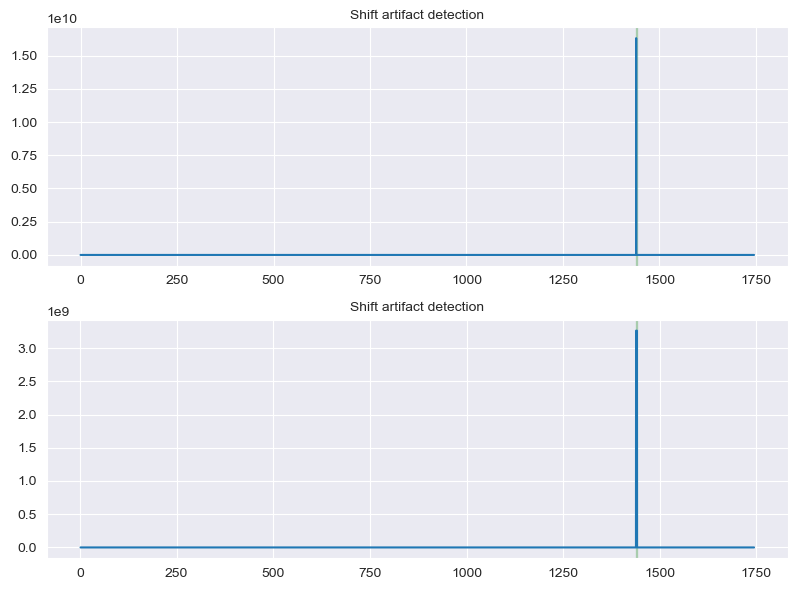

In [358]:
figure, axis = plt.subplots(2, 1, figsize=(8, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(real_time, real_nirs)
bounds = artifacts(real_nirs, real_time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Shift artifact detection', fontsize=10)
axis[1].plot(real_time, msd(real_nirs))
bounds = artifacts(real_nirs, real_time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

In [382]:
def msd(signal, width = 25):
    return pd.Series(signal).rolling(width, center=True).std().to_numpy()

def artifacts_index(signal, thresh=1000):
    msd_signal = msd(signal)
    indices = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < thresh and msd_signal[i] >= thresh) or \
            (msd_signal[i] >= thresh and msd_signal[i + 1] < thresh):
            indices.append(i)
    return indices

def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

def remove_artifacts_spline(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = spline(art_time, art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_wavelet(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = wavelet_filter(art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_mean(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        new_signal[left:right] = [0] * (right - left)
    return new_signal, indices

def shift_parts(signal, indices):
    new_signal = signal.copy()
    indices.append(len(signal))
    for i in range(len(indices) // 2):
        mean_b = np.mean(new_signal[indices[2 * i] - 100:indices[2 * i]])
        mean_a = np.mean(signal[indices[2 * i]:indices[2 * i + 1]])
        mean_c = np.mean(signal[indices[2 * i + 1]:indices[2 * i + 1]+100])
        diff_a = mean_a - mean_b
        diff_c = mean_c - mean_b
        new_signal[indices[2 * i]:indices[2 * i + 1]] = list(np.array(signal[indices[2 * i]:indices[2 * i + 1]]) - diff_a)
        new_signal[indices[2 * i + 1]:indices[2 * i + 2]] = list(np.array(signal[indices[2 * i + 1]:indices[2 * i + 2]]) - diff_c)
    return new_signal

def preprocess_spline(time, signal):
    signal, indices = remove_artifacts_spline(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_wavelet(time, signal):
    signal, indices = remove_artifacts_wavelet(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_mean(time, signal):
    signal, indices = remove_artifacts_mean(time, signal)
    signal = shift_parts(signal, indices)
    return signal

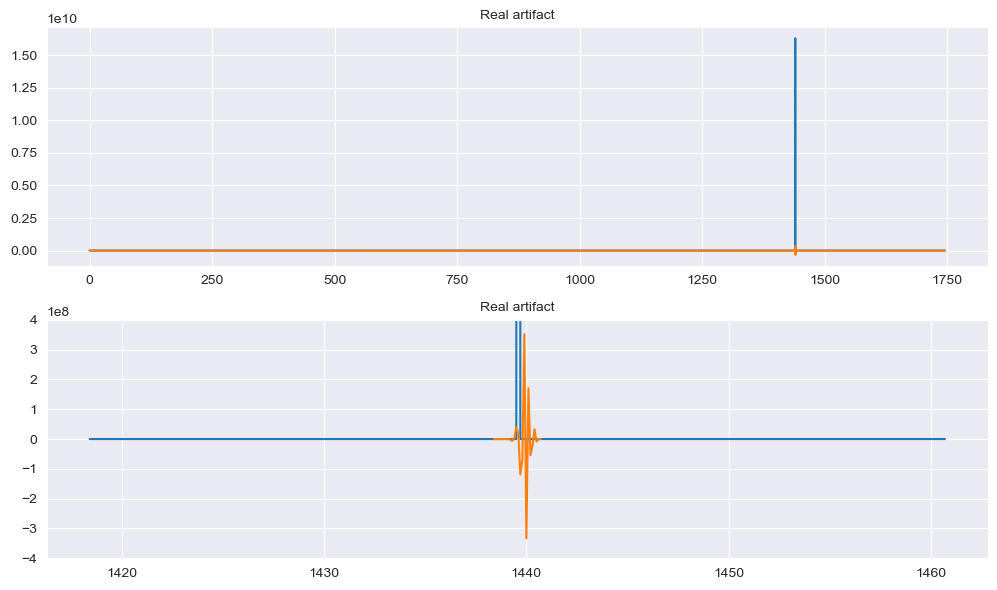

In [385]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Real artifact', fontsize=10)
axis[0].plot(real_time, real_nirs)
axis[0].plot(real_time, preprocess_wavelet(real_time, real_nirs))

indices = artifacts_index(real_nirs)
art_time, art_nirs = real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]]
axis[1].set_title('Real artifact', fontsize=10)
axis[1].set_ylim([(-4) * np.power(10, 8), 4 * np.power(10, 8)])
axis[1].plot(real_time[indices[0]-200:indices[1]+200], real_nirs[indices[0]-200:indices[1]+200])
axis[1].plot(real_time[indices[0]:indices[1]], preprocess_wavelet(real_time, real_nirs)[indices[0]:indices[1]])

plt.tight_layout()
plt.show()

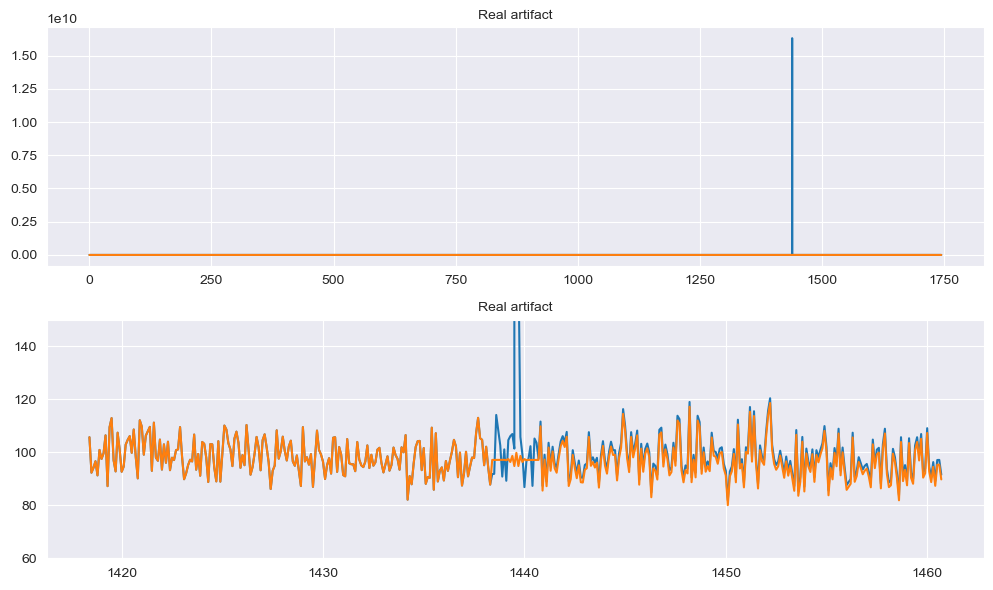

In [386]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Real artifact', fontsize=10)
axis[0].plot(real_time, real_nirs)
axis[0].plot(real_time, preprocess_spline(real_time, real_nirs))

indices = artifacts_index(real_nirs)
art_time, art_nirs = real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]]
axis[1].set_ylim([60, 150])
axis[1].set_title('Real artifact', fontsize=10)
#axis[1].plot(art_time, art_nirs)
axis[1].plot(real_time[indices[0]-200:indices[1]+200], real_nirs[indices[0]-200:indices[1]+200])
axis[1].plot(real_time[indices[0]-200:indices[1]+200], preprocess_spline(real_time, real_nirs)[indices[0]-200:indices[1]+200])


plt.tight_layout()
plt.show()

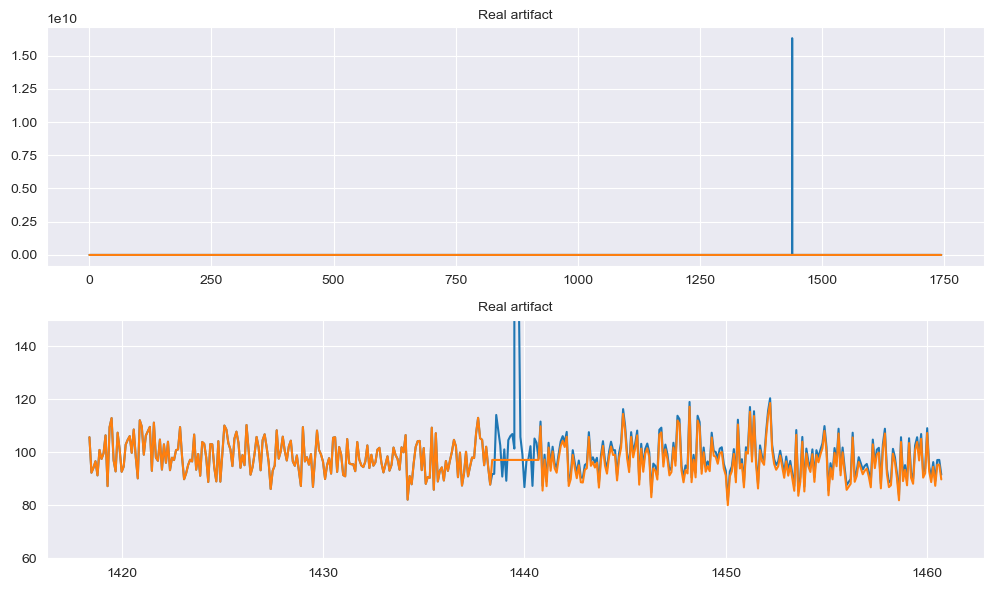

In [387]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Real artifact', fontsize=10)
axis[0].plot(real_time, real_nirs)
axis[0].plot(real_time, preprocess_mean(real_time, real_nirs))

indices = artifacts_index(real_nirs)
art_time, art_nirs = real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]]
axis[1].set_ylim([60, 150])
axis[1].set_title('Real artifact', fontsize=10)
#axis[1].plot(art_time, art_nirs)
axis[1].plot(real_time[indices[0]-200:indices[1]+200], real_nirs[indices[0]-200:indices[1]+200])
axis[1].plot(real_time[indices[0]-200:indices[1]+200], preprocess_mean(real_time, real_nirs)[indices[0]-200:indices[1]+200])


plt.tight_layout()
plt.show()

In [45]:
real_shift = pd.read_excel("data/MAN_ChLeg_MArtif.xlsx")
real_shift

,"Time, s","THb B, мкМ"
0,0.0,122.8
1,0.1,115.4
2,0.2,108.9
3,0.3,108.9
4,0.4,108.2
...,...,...
15709,1570.9,127.3
15710,1571.0,128.1
15711,1571.1,126.9
15712,1571.2,129.7


In [46]:
real_time = real_shift['Time, s'].to_list()
real_nirs = real_shift['THb B, мкМ'].to_list()

In [47]:
def msd(signal, width = 500):
    return pd.Series(signal).rolling(width, center=True).std().to_numpy()

def artifacts(signal, time):
    msd_signal = msd(signal)
    bounds = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < 10 and msd_signal[i] >= 10) or (msd_signal[i] >= 10 and msd_signal[i + 1] < 10):
            bounds.append(time[i])
    return bounds

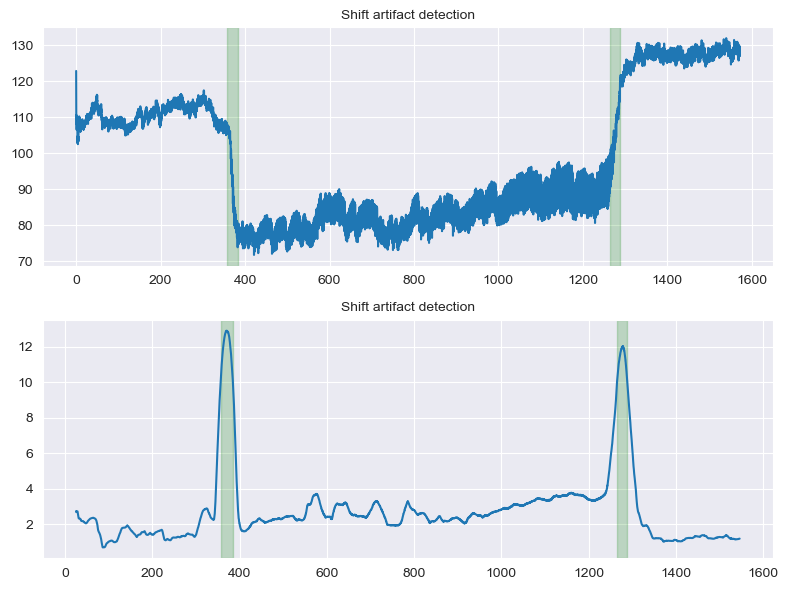

In [400]:
figure, axis = plt.subplots(2, 1, figsize=(8, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Shift artifact detection', fontsize=10)
axis[0].plot(real_time, real_nirs)
bounds = artifacts(real_nirs, real_time)
for i in range(len(bounds) // 2):
    axis[0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1].set_title('Shift artifact detection', fontsize=10)
axis[1].plot(real_time, msd(real_nirs))
bounds = artifacts(real_nirs, real_time)
for i in range(len(bounds) // 2):
    axis[1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()

In [48]:
def msd(signal, width = 500):
    return pd.Series(signal).rolling(width, center=True).std().to_numpy()

def artifacts_index(signal, thresh=10):
    msd_signal = msd(signal)
    indices = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < thresh and msd_signal[i] >= thresh) or \
            (msd_signal[i] >= thresh and msd_signal[i + 1] < thresh):
            indices.append(i)
    return indices

def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

def remove_artifacts_spline(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = spline(art_time, art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_wavelet(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = wavelet_filter(art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_mean(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        new_signal[left:right] = [0] * (right - left)
    return new_signal, indices

def shift_parts(signal, indices):
    new_signal = signal.copy()
    indices.append(len(signal))
    for i in range(len(indices) // 2):
        mean_b = np.mean(new_signal[indices[2 * i] - 100:indices[2 * i]])
        mean_a = np.mean(signal[indices[2 * i]:indices[2 * i + 1]])
        mean_c = np.mean(signal[indices[2 * i + 1]:indices[2 * i + 1]+100])
        diff_a = mean_a - mean_b
        diff_c = mean_c - mean_b
        new_signal[indices[2 * i]:indices[2 * i + 1]] = list(np.array(signal[indices[2 * i]:indices[2 * i + 1]]) - diff_a)
        new_signal[indices[2 * i + 1]:indices[2 * i + 2]] = list(np.array(signal[indices[2 * i + 1]:indices[2 * i + 2]]) - diff_c)
    return new_signal

def preprocess_spline(time, signal):
    signal, indices = remove_artifacts_spline(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_wavelet(time, signal):
    signal, indices = remove_artifacts_wavelet(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_mean(time, signal):
    signal, indices = remove_artifacts_mean(time, signal)
    signal = shift_parts(signal, indices)
    return signal

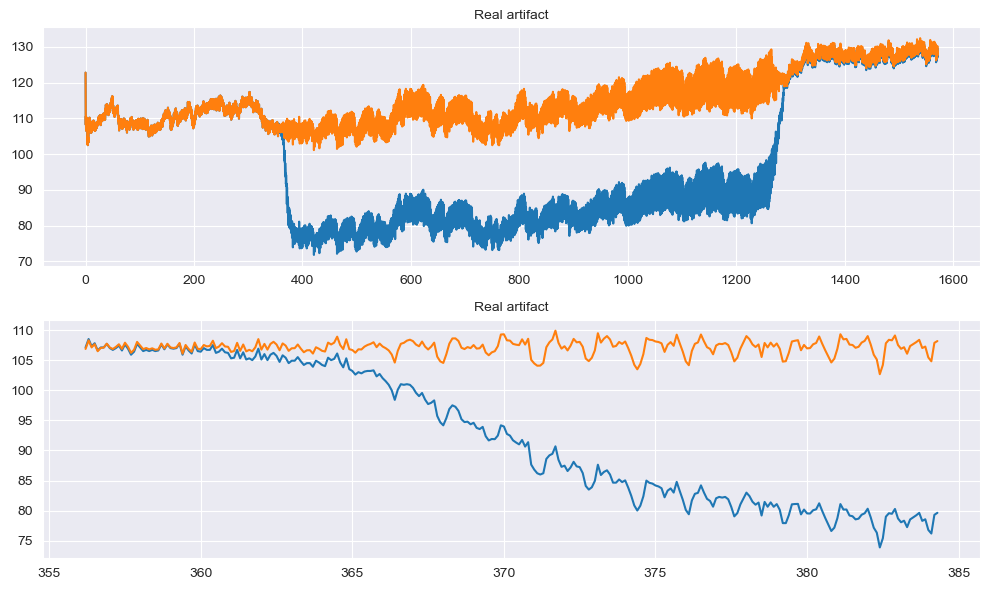

In [402]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Real artifact', fontsize=10)
axis[0].plot(real_time, real_nirs)
axis[0].plot(real_time, preprocess_wavelet(real_time, real_nirs))

indices = artifacts_index(real_nirs)
art_time, art_nirs = real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]]
axis[1].set_title('Real artifact', fontsize=10)
#axis[1].set_ylim([(-4) * np.power(10, 8), 4 * np.power(10, 8)])
axis[1].plot(real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]])
axis[1].plot(real_time[indices[0]:indices[1]], preprocess_wavelet(real_time, real_nirs)[indices[0]:indices[1]])

plt.tight_layout()
plt.show()

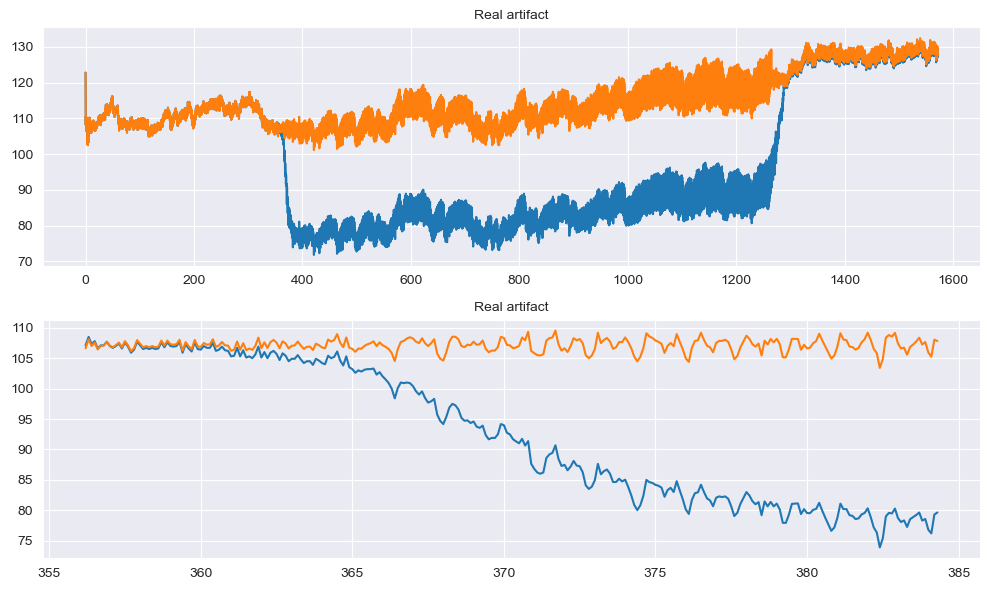

In [403]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Real artifact', fontsize=10)
axis[0].plot(real_time, real_nirs)
axis[0].plot(real_time, preprocess_spline(real_time, real_nirs))

indices = artifacts_index(real_nirs)
art_time, art_nirs = real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]]
axis[1].set_title('Real artifact', fontsize=10)
#axis[1].set_ylim([(-4) * np.power(10, 8), 4 * np.power(10, 8)])
axis[1].plot(real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]])
axis[1].plot(real_time[indices[0]:indices[1]], preprocess_spline(real_time, real_nirs)[indices[0]:indices[1]])

plt.tight_layout()
plt.show()

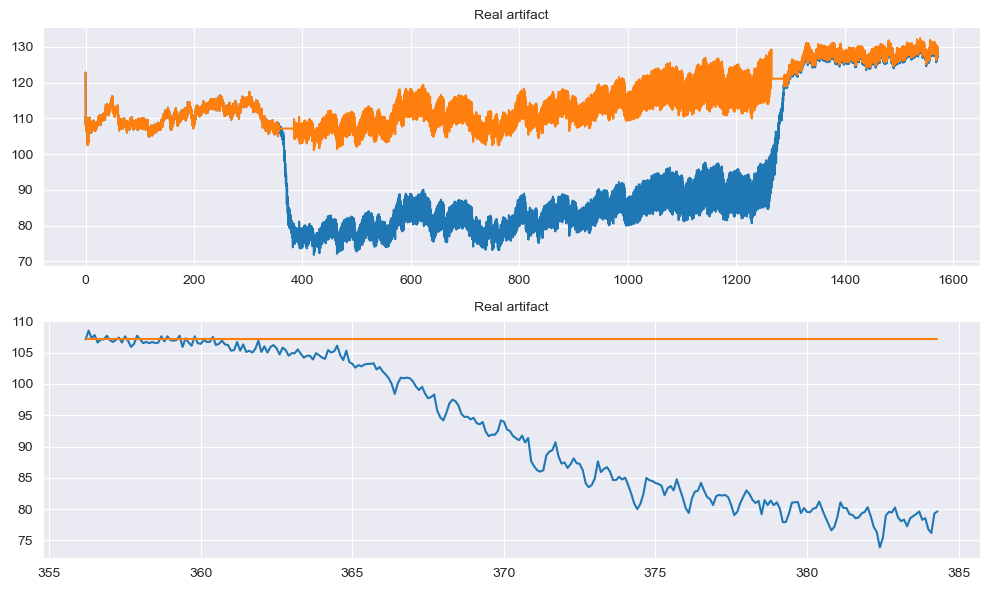

In [404]:
figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Real artifact', fontsize=10)
axis[0].plot(real_time, real_nirs)
axis[0].plot(real_time, preprocess_mean(real_time, real_nirs))

indices = artifacts_index(real_nirs)
art_time, art_nirs = real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]]
axis[1].set_title('Real artifact', fontsize=10)
#axis[1].set_ylim([(-4) * np.power(10, 8), 4 * np.power(10, 8)])
axis[1].plot(real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]])
axis[1].plot(real_time[indices[0]:indices[1]], preprocess_mean(real_time, real_nirs)[indices[0]:indices[1]])

plt.tight_layout()
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error 

In [36]:
def msd(signal, width = 25):
    return pd.Series(signal).rolling(width, center=True).std().to_numpy()

def artifacts_index(signal, thresh=10):
    msd_signal = msd(signal)
    indices = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < thresh and msd_signal[i] >= thresh) or \
            (msd_signal[i] >= thresh and msd_signal[i + 1] < thresh):
            indices.append(i)
    return indices

def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

def remove_artifacts_spline(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = spline(art_time, art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_wavelet(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = wavelet_filter(art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_mean(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        new_signal[left:right] = [0] * (right - left)
    return new_signal, indices

def shift_parts(signal, indices):
    new_signal = signal.copy()
    indices.append(len(signal))
    for i in range(len(indices) // 2):
        mean_b = np.mean(new_signal[indices[2 * i] - 100:indices[2 * i]])
        mean_a = np.mean(signal[indices[2 * i]:indices[2 * i + 1]])
        mean_c = np.mean(signal[indices[2 * i + 1]:indices[2 * i + 1]+100])
        diff_a = mean_a - mean_b
        diff_c = mean_c - mean_b
        new_signal[indices[2 * i]:indices[2 * i + 1]] = list(np.array(signal[indices[2 * i]:indices[2 * i + 1]]) - diff_a)
        new_signal[indices[2 * i + 1]:indices[2 * i + 2]] = list(np.array(signal[indices[2 * i + 1]:indices[2 * i + 2]]) - diff_c)
    return new_signal

def preprocess_spline(time, signal):
    signal, indices = remove_artifacts_spline(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_wavelet(time, signal):
    signal, indices = remove_artifacts_wavelet(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_mean(time, signal):
    signal, indices = remove_artifacts_mean(time, signal)
    signal = shift_parts(signal, indices)
    return signal

In [22]:
shift_artifact = np.array([0] * 1600 + [30] * 800 + [-80] * 1600 + [-50] * 800)
spike_artifact = np.array([0] * 800 + [150] * 1 + [0] * (2400 - 1) + [-100] * 1 + [0] * (1600 - 1))
nirs_shift = nirs_sim + shift_artifact
nirs_spike = nirs_sim + spike_artifact

In [23]:
shift_artifact = np.array([0] * 1600 + [30] * 800 + [-80] * 1600 + [-50] * 800)
spike_artifact = np.array([0] * 1600 + [50] * 1 + [0] * (2400 - 1) + [-100] * 1 + [0] * (800 - 1))
nirs_both = nirs_sim + shift_artifact + spike_artifact

In [32]:
spline_error = 0
spline_error += mean_squared_error(nirs_sim, preprocess_spline(time, nirs_shift))
spline_error += mean_squared_error(nirs_sim, preprocess_spline(time, nirs_spike))
spline_error += mean_squared_error(nirs_sim, preprocess_spline(time, nirs_both))
spline_error

474.0030451366182

In [33]:
wavelet_error = 0
wavelet_error += mean_squared_error(nirs_sim, preprocess_wavelet(time, nirs_shift))
wavelet_error += mean_squared_error(nirs_sim, preprocess_wavelet(time, nirs_spike))
wavelet_error += mean_squared_error(nirs_sim, preprocess_wavelet(time, nirs_both))
wavelet_error

474.0481651346771

In [34]:
mean_error = 0
mean_error += mean_squared_error(nirs_sim, preprocess_mean(time, nirs_shift))
mean_error += mean_squared_error(nirs_sim, preprocess_mean(time, nirs_spike))
mean_error += mean_squared_error(nirs_sim, preprocess_mean(time, nirs_both))
mean_error

474.10394348595145

In [35]:
print(mean_squared_error(nirs_sim, preprocess_spline(time, nirs_shift)))
print(mean_squared_error(nirs_sim, preprocess_spline(time, nirs_spike)))
print(mean_squared_error(nirs_sim, preprocess_spline(time, nirs_both)))

192.04863128617086
104.18462404496648
177.76978980548088


In [55]:
def msd(signal, width = 500):
    return pd.Series(signal).rolling(width, center=True).std().to_numpy()

def artifacts_index(signal, thresh=10):
    msd_signal = msd(signal)
    indices = []
    for i in range(1, len(msd_signal)):
        if (msd_signal[i - 1] < thresh and msd_signal[i] >= thresh) or \
            (msd_signal[i] >= thresh and msd_signal[i + 1] < thresh):
            indices.append(i)
    return indices

def spline(time, signal):
    tck = splrep(time, signal, s=len(time))
    return BSpline(*tck)(time)

def wavelet_filter(signal, thresh = 0.1, wavelet="db5"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="hard") for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    if len(reconstructed_signal) < len(signal):
        for i in range(len(signal) - len(reconstructed_signal)):
            reconstructed_signal.append(reconstructed_signal[-1])
    elif len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]
    return reconstructed_signal

def remove_artifacts_spline(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = spline(art_time, art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_wavelet(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        art_time, art_nirs = time[left:right], signal[left:right]
        trend = wavelet_filter(art_nirs)
        new_signal[left:right] = list(map(operator.sub, art_nirs, trend))
    return new_signal, indices

def remove_artifacts_mean(time, signal):
    indices = artifacts_index(signal)
    new_signal = signal.copy()
    for i in range(len(indices) // 2):
        left = indices[2 * i]
        right = indices[2 * i + 1]
        new_signal[left:right] = [0] * (right - left)
    return new_signal, indices

def shift_parts(signal, indices, width=1000):
    new_signal = signal.copy()
    indices.append(len(signal))
    for i in range(len(indices) // 2):
        mean_b = np.mean(new_signal[indices[2 * i] - width:indices[2 * i]])
        mean_a = np.mean(signal[indices[2 * i]:indices[2 * i + 1]])
        mean_c = np.mean(signal[indices[2 * i + 1]:indices[2 * i + 1]+width])
        diff_a = mean_a - mean_b
        diff_c = mean_c - mean_b
        new_signal[indices[2 * i]:indices[2 * i + 1]] = list(np.array(signal[indices[2 * i]:indices[2 * i + 1]]) - diff_a)
        new_signal[indices[2 * i + 1]:indices[2 * i + 2]] = list(np.array(signal[indices[2 * i + 1]:indices[2 * i + 2]]) - diff_c)
    return new_signal

def preprocess_spline(time, signal):
    signal, indices = remove_artifacts_spline(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_wavelet(time, signal):
    signal, indices = remove_artifacts_wavelet(time, signal)
    signal = shift_parts(signal, indices)
    return signal

def preprocess_mean(time, signal):
    signal, indices = remove_artifacts_mean(time, signal)
    signal = shift_parts(signal, indices)
    return signal

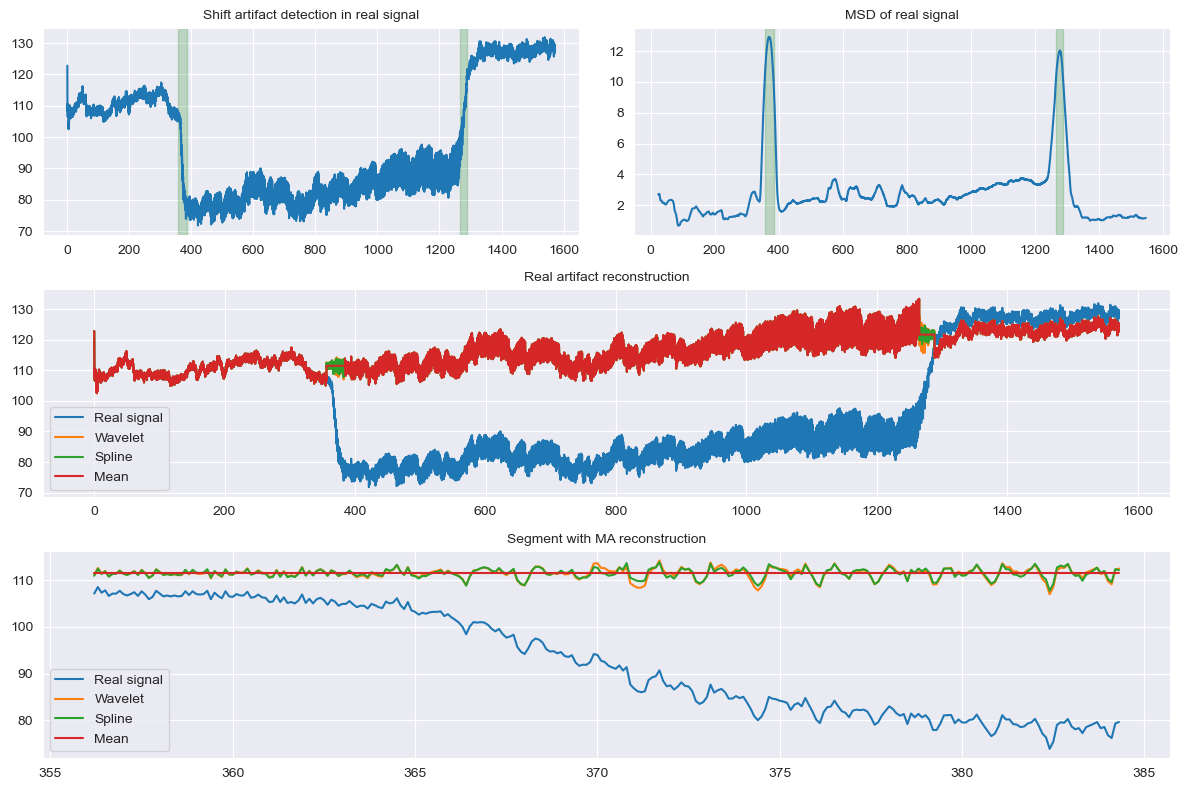

In [59]:
figure, axis = plt.subplot_mosaic("AB;CC;DD", figsize=(12, 8))
#plt.subplots_adjust(hspace=1.0)
axis["A"].set_title('Shift artifact detection in real signal', fontsize=10)
axis["A"].plot(real_time, real_nirs)
bounds = artifacts(real_nirs, real_time)
for i in range(len(bounds) // 2):
    axis["A"].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis["B"].set_title('MSD of real signal', fontsize=10)
axis["B"].plot(real_time, msd(real_nirs))
bounds = artifacts(real_nirs, real_time)
for i in range(len(bounds) // 2):
    axis["B"].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis["C"].set_title('Real artifact reconstruction', fontsize=10)
axis["C"].plot(real_time, real_nirs)
axis["C"].plot(real_time, preprocess_wavelet(real_time, real_nirs))
axis["C"].plot(real_time, preprocess_spline(real_time, real_nirs))
axis["C"].plot(real_time, preprocess_mean(real_time, real_nirs))
axis["C"].legend(["Real signal", "Wavelet", "Spline", "Mean"])


indices = artifacts_index(real_nirs)
art_time, art_nirs = real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]]
axis["D"].set_title('Segment with MA reconstruction', fontsize=10)
#axis[1].set_ylim([(-4) * np.power(10, 8), 4 * np.power(10, 8)])
axis["D"].plot(real_time[indices[0]:indices[1]], real_nirs[indices[0]:indices[1]])
axis["D"].plot(real_time[indices[0]:indices[1]], preprocess_wavelet(real_time, real_nirs)[indices[0]:indices[1]])
axis["D"].plot(real_time[indices[0]:indices[1]], preprocess_spline(real_time, real_nirs)[indices[0]:indices[1]])
axis["D"].plot(real_time[indices[0]:indices[1]], preprocess_mean(real_time, real_nirs)[indices[0]:indices[1]])
axis["D"].legend(["Real signal", "Wavelet", "Spline", "Mean"])

plt.tight_layout()
plt.show()

In [ ]:
figure, axis = plt.subplots(3, 2, figsize=(12, 6), width_ratios=[2, 1])
#plt.subplots_adjust(hspace=1.0)
axis[0, 0].set_title('Shift artifact detection', fontsize=10)
axis[0, 0].plot(time, nirs_shift)
axis[0, 0].plot(time, preprocess_spline(time, nirs_shift))
axis[0, 0].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0, 0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[0, 1].set_title('Shift artifact MSD', fontsize=10)
axis[0, 1].plot(time, msd(nirs_shift))
bounds = artifacts(nirs_shift, time)
for i in range(len(bounds) // 2):
    axis[0, 1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1, 0].set_title('Spike artifact detection', fontsize=10)
axis[1, 0].plot(time, nirs_spike)
axis[1, 0].plot(time, preprocess_spline(time, nirs_spike))
axis[1, 0].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1, 0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[1, 1].set_title('Spike artifact MSD', fontsize=10)
axis[1, 1].plot(time, msd(nirs_spike))
bounds = artifacts(nirs_spike, time)
for i in range(len(bounds) // 2):
    axis[1, 1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2, 0].set_title('Both artifacts detection', fontsize=10)
axis[2, 0].plot(time, nirs_both)
axis[2, 0].plot(time, preprocess_spline(time, nirs_both))
axis[2, 0].legend(["Signal with MA", "Reconstruction"])
bounds = artifacts(nirs_both, time)
for i in range(len(bounds) // 2):
    axis[2, 0].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

axis[2, 1].set_title('Both artifacts MSD', fontsize=10)
axis[2, 1].plot(time, msd(nirs_both))
bounds = artifacts(nirs_both, time)
for i in range(len(bounds) // 2):
    axis[2, 1].axvspan(bounds[2 * i], bounds[2 * i + 1], color='green', alpha=0.2)

plt.tight_layout()
plt.show()